# **Segmentação de clientes**

In [225]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# pip install yellowbrick

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
from datetime import datetime, timedelta

%matplotlib inline

In [226]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [227]:
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

## Carregamento de dados

In [228]:
df_vendas = pd.read_csv('data/TFvenda.csv')
df_clientes = pd.read_csv('data/DimCliente.csv')
df_produtos = pd.read_csv('data/DimProduto.csv')
df_tempo = pd.read_csv('data/DimTempo.csv')

In [229]:
df_vendas

,VendaId,DataId,ClienteId,ProdutoId,Quantidade,PrecoUnitario,PercentagemDesconto,ValorTotal,Canal
0,1,2021-07-06,100,72,2,71.51,50.0,143.02,Online
1,2,2021-09-17,100,64,1,124.16,10.0,124.16,Online
2,3,2021-09-18,100,66,2,28.69,25.0,57.37,Online
3,4,2021-09-19,100,40,1,61.04,8.0,61.04,Online
4,5,2021-10-22,100,124,3,20.53,50.0,61.58,Online
...,...,...,...,...,...,...,...,...,...
35819,36731,2012-11-29,2099,95,2,15.06,0.0,30.11,Loja Física
35820,36732,2012-12-05,2099,69,3,26.81,10.0,80.42,Loja Física
35821,36733,2012-12-08,2099,35,1,30.11,50.0,30.11,Loja Física
35822,36734,2014-12-29,2099,125,3,29.06,10.0,87.17,Loja Física


In [230]:
df_clientes

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20
3,103,Pilar Batista,Feminino,Casado,Professor,Guimarães,Braga,1972-02-11
4,104,César Costa,Masculino,Casado,Arquiteto,Porto,Porto,1995-04-25
...,...,...,...,...,...,...,...,...
1895,2095,Mia Silva,Feminino,Casado,Comerciante,Vila Nova de Gaia,Porto,1970-06-17
1896,2096,Ivan Lopes,Masculino,Solteiro,Engenheiro,Lagoa,Faro,1996-09-22
1897,2097,Emma Abreu,Feminino,Solteiro,Analista de Dados,Miranda do Douro,Bragança,1986-08-11
1898,2098,Madalena Costa,Feminino,Solteiro,Motorista,Alcobaça,Leiria,1972-06-07


In [231]:
df_produtos

,ProdutoId,Nome,Marca,Categoria
0,1,Rato Logitech MX Master,Logitech,Perifericos
1,2,Logitech Rato MX Anywhere,Logitech,Perifericos
2,3,Teclado Mecânico Corsair K70,Corsair,Perifericos
3,4,Teclado Gaming Razer BlackWidow,Razer,Perifericos
4,5,"Monitor Dell 24"",Dell,Monitores\n6,Monitor 27 ...",HP,Monitores
...,...,...,...,...
168,171,Rato SteelSeries Rival 5,SteelSeries,Perifericos
169,172,Teclado Razer Pro Type,Razer,Perifericos
170,173,"Monitor 27 ASUS ProArt""",ASUS,Monitores
171,174,Headset Sennheiser HD 560S,Sennheiser,Audio


In [232]:
df_tempo

,DataId,Mes,Trimestre,Ano,FimDeSemana,Feriado
0,2010-01-01,1,1,2010,N,S
1,2010-01-02,1,1,2010,S,S
2,2010-01-03,1,1,2010,S,S
3,2010-01-04,1,1,2010,N,S
4,2010-01-05,1,1,2010,N,S
...,...,...,...,...,...,...
5539,2025-04-08,4,2,2025,N,S
5540,2025-04-09,4,2,2025,N,S
5541,2025-04-10,4,2,2025,N,S
5542,2025-04-11,4,2,2025,N,S


In [233]:
df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35824 entries, 0 to 35823
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   VendaId              35824 non-null  int64  
 1   DataId               35824 non-null  object 
 2   ClienteId            35824 non-null  int64  
 3   ProdutoId            35824 non-null  int64  
 4   Quantidade           35824 non-null  int64  
 5   PrecoUnitario        35824 non-null  float64
 6   PercentagemDesconto  35824 non-null  float64
 7   ValorTotal           35824 non-null  float64
 8   Canal                35782 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 2.5+ MB


In [234]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ClienteId       1900 non-null   int64 
 1   Nome            1900 non-null   object
 2   Sexo            1900 non-null   object
 3   EstadoCivil     1900 non-null   object
 4   Profissão       1900 non-null   object
 5   Concelho        1900 non-null   object
 6   Distrito        1900 non-null   object
 7   DataNascimento  1900 non-null   object
dtypes: int64(1), object(7)
memory usage: 118.9+ KB


In [235]:
df_produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ProdutoId  173 non-null    int64 
 1   Nome       173 non-null    object
 2   Marca      173 non-null    object
 3   Categoria  173 non-null    object
dtypes: int64(1), object(3)
memory usage: 5.5+ KB


In [236]:
df_tempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5544 entries, 0 to 5543
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DataId       5544 non-null   object
 1   Mes          5544 non-null   int64 
 2   Trimestre    5544 non-null   int64 
 3   Ano          5544 non-null   int64 
 4   FimDeSemana  5544 non-null   object
 5   Feriado      5544 non-null   object
dtypes: int64(3), object(3)
memory usage: 260.0+ KB


## Analise de dados

### Percentagem de compras por distrito
Identificar zonas com maior volume de negócio e zonas com menos. Útil para justificar a abertura de uma nova localização

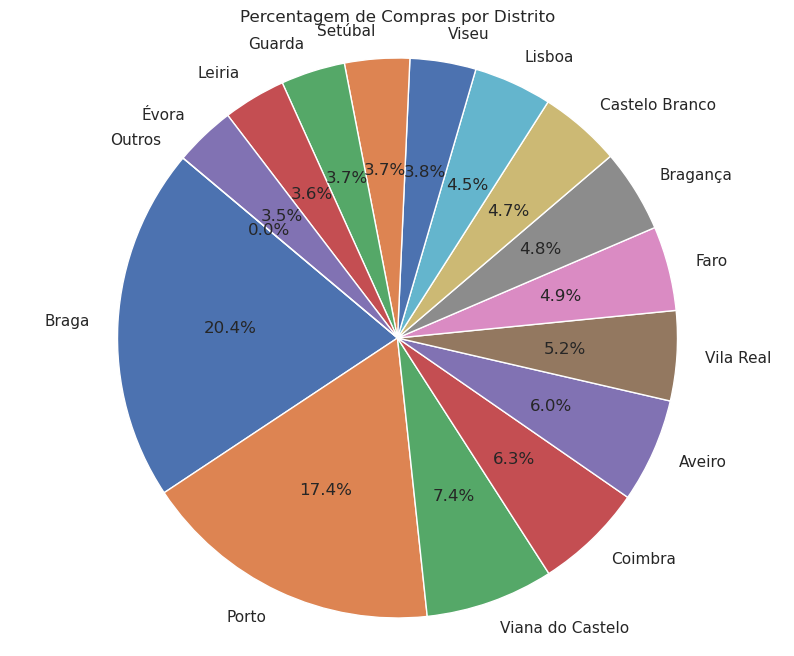

In [237]:
df_vendas_com_distrito = df_vendas.merge(df_clientes[['ClienteId', 'Distrito']], on='ClienteId', how='left')

compras_por_distrito = df_vendas_com_distrito['Distrito'].value_counts()

percentagem_por_distrito = compras_por_distrito / compras_por_distrito.sum() * 100

principais = percentagem_por_distrito[percentagem_por_distrito >= 3]
residuais = percentagem_por_distrito[percentagem_por_distrito < 2]

principais['Outros'] = residuais.sum()

plt.figure(figsize=(10, 8))
plt.pie(principais, labels=principais.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentagem de Compras por Distrito')
plt.axis('equal')
plt.show()

## Percentagem de compras online VS Percentagem de compras em loja fisica
Perceber se os clientes usam mais as lojas fisicas ou a loja online. <br>
Se o objetivo é aumentar o volume de vendas da loja online pode ser razoável criar campanhas específicas para a mesma.

In [238]:
compras_online = df_vendas[df_vendas['Canal'] == 'Online']
compras_loja = df_vendas[df_vendas['Canal'] == 'Loja Física']

print(f"Número de compras online: {compras_online.shape[0]}")
print(f"Número de compras na loja: {compras_loja.shape[0]}")

fig = go.Figure(data=[go.Pie(labels=['Online', 'Loja Física'],
                             values=[compras_online.shape[0], compras_loja.shape[0]])])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text="Distribuição de Compras por Canal")
fig.show()

Número de compras online: 17770
Número de compras na loja: 18012


### Percentagem de compras por profissão
Tentar perceber se clientes com profissões mais ligadas a IT compram mais na loja. <br>
Se uma certa profissão está associada a um maior volume de vendas, pode fazer sentido para o negócio aumentar a oferta de produtos usados pelos profissionais em questão.

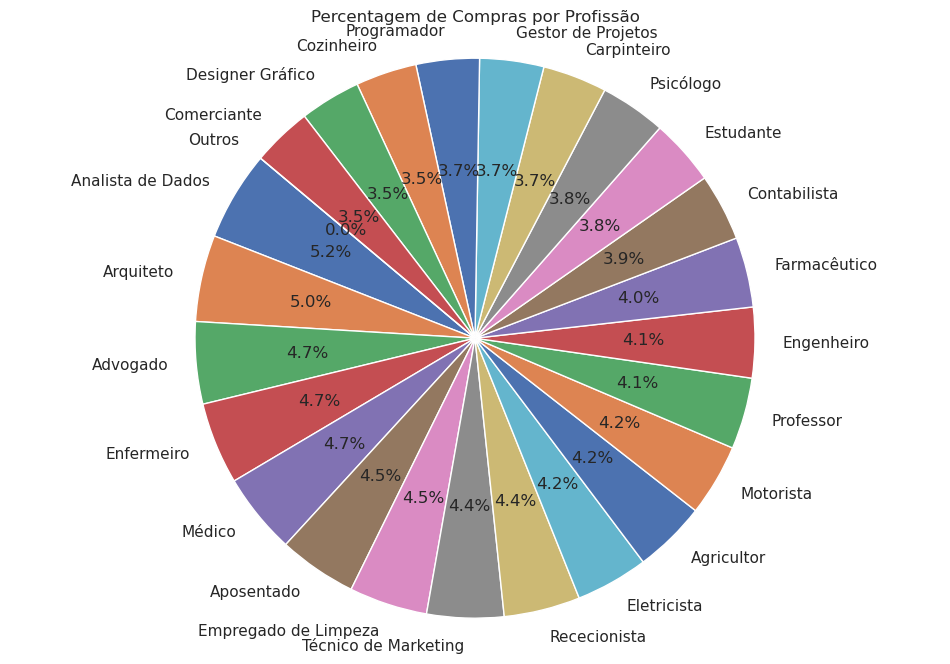

In [239]:
df_vendas_com_profissao = df_vendas.merge(df_clientes[['ClienteId', 'Profissão']], on='ClienteId', how='left')

compras_por_profissao = df_vendas_com_profissao['Profissão'].value_counts()

percentagem_por_profissao = compras_por_profissao / compras_por_profissao.sum() * 100

principais_profissoes = percentagem_por_profissao[percentagem_por_profissao >= 3]
residuais_profissoes = percentagem_por_profissao[percentagem_por_profissao < 3]

principais_profissoes['Outros'] = residuais_profissoes.sum()

plt.figure(figsize=(12, 8))
plt.pie(principais_profissoes, labels=principais_profissoes.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentagem de Compras por Profissão')
plt.axis('equal')
plt.show()


### Percentagem de cada categoria de produto nas compras
Identificar categorias de produto mais compradas para aumentar a oferta das mesmas

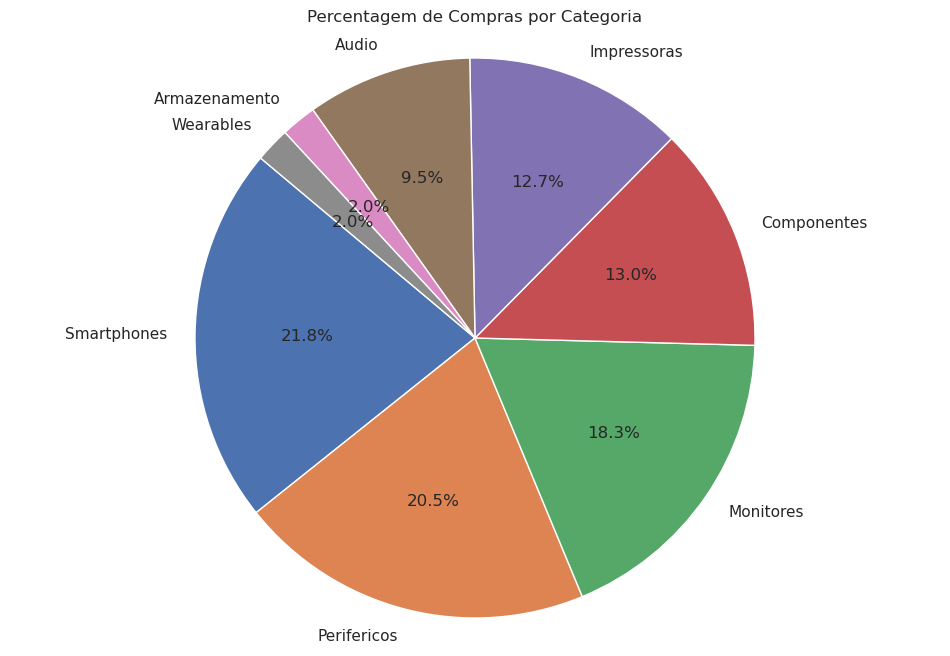

In [240]:
compras_por_categoria = df_vendas.merge(df_produtos[['ProdutoId', 'Categoria']], on='ProdutoId', how='left')
compras_por_categoria = compras_por_categoria['Categoria'].value_counts()
percentagem_por_categoria = compras_por_categoria / compras_por_categoria.sum() * 100
plt.figure(figsize=(12, 8))
plt.pie(percentagem_por_categoria, labels=percentagem_por_categoria.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentagem de Compras por Categoria')
plt.axis('equal')
plt.show()

## Feature engineering

### PrecoFinal
Preço final de uma compra considerando a quntidade, preço unitário e o desconto por unidade

In [241]:
df_vendas['PrecoFinal'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)
df_vendas.head()

,VendaId,DataId,ClienteId,ProdutoId,Quantidade,PrecoUnitario,PercentagemDesconto,ValorTotal,Canal,PrecoFinal
0,1,2021-07-06,100,72,2,71.51,50.0,143.02,Online,71.5100
1,2,2021-09-17,100,64,1,124.16,10.0,124.16,Online,111.7440
2,3,2021-09-18,100,66,2,28.69,25.0,57.37,Online,43.0350
3,4,2021-09-19,100,40,1,61.04,8.0,61.04,Online,56.1568
4,5,2021-10-22,100,124,3,20.53,50.0,61.58,Online,30.7950


### Idade

In [242]:
df_clientes['DataNascimento'] = pd.to_datetime(df_clientes['DataNascimento'])

today = pd.Timestamp.today()
df_clientes['Idade'] = df_clientes['DataNascimento'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))

df_clientes.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20,23
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20,31
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20,22
3,103,Pilar Batista,Feminino,Casado,Professor,Guimarães,Braga,1972-02-11,53
4,104,César Costa,Masculino,Casado,Arquiteto,Porto,Porto,1995-04-25,30


### Percentagem de compras online

In [243]:
compras_online = df_vendas[df_vendas['Canal'] == 'Online'].groupby('ClienteId').size()

compras_totais = df_vendas.groupby('ClienteId').size()

percentagem_online = (compras_online / compras_totais * 100)

df_clientes['PercentagemComprasOnline'] = df_clientes['ClienteId'].map(percentagem_online).fillna(0)

df_clientes.head()


,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20,23,44.444444
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20,31,66.666667
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20,22,50.000000
3,103,Pilar Batista,Feminino,Casado,Professor,Guimarães,Braga,1972-02-11,53,63.157895
4,104,César Costa,Masculino,Casado,Arquiteto,Porto,Porto,1995-04-25,30,52.173913


### Frequencia
Total de transações e de produtos comprados

In [244]:
df_vendas['VendaId'] = df_vendas['DataId'].astype(str) + '_' + df_vendas['ClienteId'].astype(str)

total_transacoes = df_vendas.groupby('ClienteId')['VendaId'].nunique().reset_index()
total_transacoes.rename(columns={'VendaId': 'TotalTransacoes'}, inplace=True)

total_compras = df_vendas.groupby('ClienteId')['Quantidade'].sum().reset_index()
total_compras.rename(columns={'Quantidade': 'TotalCompras'}, inplace=True)

df_clientes = pd.merge(df_clientes, total_transacoes, on='ClienteId', how='left')
df_clientes = pd.merge(df_clientes, total_compras, on='ClienteId', how='left')

df_clientes.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,TotalTransacoes,TotalCompras
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20,23,44.444444,26,58
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20,31,66.666667,18,36
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20,22,50.000000,11,24


### Total gasto e Valor Médio de transações

In [245]:
df_vendas['Total_Spend'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)
total_spend = df_vendas.groupby('ClienteId')['Total_Spend'].sum().reset_index()

total_transactions = df_vendas.groupby('ClienteId').size().reset_index(name='Total_Transactions')

average_transaction_value = total_spend.merge(total_transactions, on='ClienteId')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

customer_data = df_clientes.copy()

customer_data = pd.merge(customer_data, total_spend, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, average_transaction_value[['ClienteId', 'Average_Transaction_Value']], on='ClienteId', how='left')

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,TotalTransacoes,TotalCompras,Total_Spend,Average_Transaction_Value
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20,23,44.444444,26,58,6055.0081,224.259559
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20,31,66.666667,18,36,1536.4501,85.358339
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20,22,50.000000,11,24,1932.7504,161.062533


### Diversidade de produtos

Produtos unicos comprados

In [246]:
unique_products_purchased = df_vendas.groupby('ClienteId')['ProdutoId'].nunique().reset_index()
unique_products_purchased.rename(columns={'ProdutoId': 'ProdutosUnicosComprados'}, inplace=True)

customer_data = pd.merge(customer_data, unique_products_purchased, on='ClienteId')

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,TotalTransacoes,TotalCompras,Total_Spend,Average_Transaction_Value,ProdutosUnicosComprados
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20,23,44.444444,26,58,6055.0081,224.259559,26
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20,31,66.666667,18,36,1536.4501,85.358339,17
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20,22,50.000000,11,24,1932.7504,161.062533,12


### Media de dias entre compras e Dia e Hora favoritos para comprar

In [247]:
# Convert date and create time features
df_vendas['DataCompra'] = pd.to_datetime(df_vendas['DataId'])
df_vendas['Day_Of_Week'] = df_vendas['DataCompra'].dt.dayofweek
df_vendas['Hour'] = 12  # Placeholder/default hour
df_vendas = df_vendas.sort_values(['ClienteId', 'DataCompra'])
df_vendas['InvoiceDay'] = df_vendas['DataCompra'].dt.date

# Calculate days between purchases (only for customers with >1 purchase)
days_between_purchases = df_vendas.groupby('ClienteId')['InvoiceDay'].apply(
    lambda x: (x.diff()).dropna().apply(lambda y: y.days)
)

# Calculate average days between purchases
average_days_between_purchases = days_between_purchases.groupby('ClienteId').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find favorite shopping day
favorite_shopping_day = df_vendas.groupby(['ClienteId', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('ClienteId')['Count'].idxmax()][['ClienteId', 'Day_Of_Week']]

# Find favorite shopping hour
favorite_shopping_hour = df_vendas.groupby(['ClienteId', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('ClienteId')['Count'].idxmax()][['ClienteId', 'Hour']]

# Merge features into customer_data
customer_data = customer_data.copy()
customer_data = pd.merge(customer_data, average_days_between_purchases, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='ClienteId', how='left')

# Map day of week numbers to day names
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
customer_data['Favorite_Shopping_Day'] = customer_data['Day_Of_Week'].map(day_mapping)

# Preview result
customer_data.head(3)


,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,TotalTransacoes,TotalCompras,Total_Spend,Average_Transaction_Value,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20,23,44.444444,26,58,6055.0081,224.259559,26,187.346154,4,12,Friday
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20,31,66.666667,18,36,1536.4501,85.358339,17,298.411765,1,12,Tuesday
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20,22,50.000000,11,24,1932.7504,161.062533,12,444.090909,3,12,Thursday


### Media de gastos mensais

In [248]:
df_vendas['DataCompra'] = pd.to_datetime(df_vendas['DataId'])

df_vendas['Year'] = df_vendas['DataCompra'].dt.year
df_vendas['Month'] = df_vendas['DataCompra'].dt.month

if 'Total_Spend' not in df_vendas.columns:
    df_vendas['Total_Spend'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)

monthly_spending = df_vendas.groupby(['ClienteId', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

seasonal_buying_patterns = monthly_spending.groupby('ClienteId')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

def calculate_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    else:
        return 0

spending_trends = monthly_spending.groupby('ClienteId')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

if 'customer_data' not in locals():
    customer_data = df_clientes.copy()

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, spending_trends, on='ClienteId', how='left')

customer_data['Monthly_Spending_Mean'] = customer_data['Monthly_Spending_Mean'].apply(lambda x: -1 if x == 0.0 else x)
customer_data['Spending_Trend'] = customer_data['Spending_Trend'].apply(lambda x: -1 if x == 0.0 else x)
customer_data['Monthly_Spending_Std'] = customer_data['Monthly_Spending_Std'].apply(lambda x: -1 if x == 0.0 else x)

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Total_Spend,Average_Transaction_Value,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20,23,44.444444,...,6055.0081,224.259559,26,187.346154,4,12,Friday,288.333719,502.490890,6.800584
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20,31,66.666667,...,1536.4501,85.358339,17,298.411765,1,12,Tuesday,109.746436,149.995418,-1.223360
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20,22,50.000000,...,1932.7504,161.062533,12,444.090909,3,12,Thursday,193.275040,280.582672,29.272781


In [249]:
customer_data['ClienteId'] = customer_data['ClienteId'].astype(str)

customer_data = customer_data.convert_dtypes()

customer_data.head(10)

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Total_Spend,Average_Transaction_Value,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20,23,44.444444,...,6055.0081,224.259559,26,187.346154,4,12,Friday,288.333719,502.49089,6.800584
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20,31,66.666667,...,1536.4501,85.358339,17,298.411765,1,12,Tuesday,109.746436,149.995418,-1.22336
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20,22,50.0,...,1932.7504,161.062533,12,444.090909,3,12,Thursday,193.27504,280.582672,29.272781
3,103,Pilar Batista,Feminino,Casado,Professor,Guimarães,Braga,1972-02-11,53,63.157895,...,1569.6721,82.614321,19,264.5,4,12,Friday,142.697464,174.265272,8.724591
4,104,César Costa,Masculino,Casado,Arquiteto,Porto,Porto,1995-04-25,30,52.173913,...,5788.042,251.654,19,208.181818,6,12,Sunday,361.752625,307.558336,-14.828133
5,105,Fabiana Brito,Feminino,Casado,Professor,Arganil,Coimbra,1971-06-06,53,68.421053,...,4412.6734,232.245968,16,302.888889,1,12,Tuesday,339.436415,595.136118,39.907108
6,106,Tiago Pereira,Masculino,Solteiro,Médico,Fafe,Braga,1969-12-09,55,53.571429,...,3076.7088,109.882457,22,194.444444,2,12,Wednesday,180.982871,214.770015,5.750898
7,108,Yara Fonseca,Feminino,Solteiro,Farmacêutico,Carregal do Sal,Viseu,1989-07-16,35,55.555556,...,2525.1658,93.524659,25,198.346154,5,12,Saturday,132.903463,103.406101,-1.537724
8,110,Maria Amorim,Feminino,Viúvo,Comerciante,Amares,Braga,1992-11-20,32,31.25,...,3365.5122,210.344513,14,355.133333,3,12,Thursday,305.955655,357.716401,-16.357409
9,111,Lia Guerreiro,Feminino,Casado,Médico,Portimão,Faro,1967-12-29,57,26.315789,...,5785.4028,304.494884,18,236.444444,2,12,Wednesday,413.243057,436.141398,-22.903268


### Recência da primeira compra

Perceber se o cliente é efetivamente novo ou se apenas comprou uma veze e não voltou

In [250]:
df_vendas['DataCompra'] = pd.to_datetime(df_vendas['DataId'])

last_date_in_data = df_vendas['DataCompra'].max()

first_purchase_dates = df_vendas.groupby('ClienteId')['DataCompra'].min().reset_index()
first_purchase_dates.rename(columns={'DataCompra': 'First_Purchase_Date'}, inplace=True)

first_purchase_dates['Recency_First_Purchase_Days'] = (
    last_date_in_data - first_purchase_dates['First_Purchase_Date']
).dt.days

customer_data['ClienteId'] = customer_data['ClienteId'].astype(str)
first_purchase_dates['ClienteId'] = first_purchase_dates['ClienteId'].astype(str)

customer_data = pd.merge(
    customer_data,
    first_purchase_dates[['ClienteId', 'Recency_First_Purchase_Days']],
    on='ClienteId',
    how='left'
)

customer_data.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Average_Transaction_Value,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Recency_First_Purchase_Days
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20,23,44.444444,...,224.259559,26,187.346154,4,12,Friday,288.333719,502.49089,6.800584,5182
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20,31,66.666667,...,85.358339,17,298.411765,1,12,Tuesday,109.746436,149.995418,-1.22336,5192
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20,22,50.0,...,161.062533,12,444.090909,3,12,Thursday,193.27504,280.582672,29.272781,5326
3,103,Pilar Batista,Feminino,Casado,Professor,Guimarães,Braga,1972-02-11,53,63.157895,...,82.614321,19,264.5,4,12,Friday,142.697464,174.265272,8.724591,5160
4,104,César Costa,Masculino,Casado,Arquiteto,Porto,Porto,1995-04-25,30,52.173913,...,251.654,19,208.181818,6,12,Sunday,361.752625,307.558336,-14.828133,4663


### Categoria mais comprada

In [251]:
df_vendas = df_vendas.merge(df_produtos[['ProdutoId', 'Categoria']], on='ProdutoId', how='left')

compras_por_categoria = df_vendas.groupby(['ClienteId', 'Categoria']).size().reset_index(name='NumCompras')

categoria_favorita = compras_por_categoria.loc[
    compras_por_categoria.groupby('ClienteId')['NumCompras'].idxmax()
]

categoria_favorita.rename(columns={'Categoria': 'CategoriaFavorita'}, inplace=True)

customer_data['ClienteId'] = customer_data['ClienteId'].astype('int64')
categoria_favorita['ClienteId'] = categoria_favorita['ClienteId'].astype('int64')

customer_data = customer_data.merge(categoria_favorita[['ClienteId', 'CategoriaFavorita']], on='ClienteId', how='left')

customer_data.head(3)


,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Recency_First_Purchase_Days,CategoriaFavorita
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20,23,44.444444,...,26,187.346154,4,12,Friday,288.333719,502.49089,6.800584,5182,Perifericos
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20,31,66.666667,...,17,298.411765,1,12,Tuesday,109.746436,149.995418,-1.22336,5192,Perifericos
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20,22,50.0,...,12,444.090909,3,12,Thursday,193.27504,280.582672,29.272781,5326,Componentes


In [252]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ClienteId                       1900 non-null   int64         
 1   Nome                            1900 non-null   string        
 2   Sexo                            1900 non-null   string        
 3   EstadoCivil                     1900 non-null   string        
 4   Profissão                       1900 non-null   string        
 5   Concelho                        1900 non-null   string        
 6   Distrito                        1900 non-null   string        
 7   DataNascimento                  1900 non-null   datetime64[ns]
 8   Idade                           1900 non-null   Int64         
 9   PercentagemComprasOnline        1900 non-null   Float64       
 10  TotalTransacoes                 1900 non-null   Int64         
 11  Tota

## Deteção e tratamento de outliers

In [253]:
model = IsolationForest(contamination=0.05, random_state=0)

numeric_columns = customer_data.select_dtypes(include=['number']).columns

numeric_data = customer_data[numeric_columns].fillna(customer_data[numeric_columns].mean())

customer_data['Outlier_Scores'] = model.fit_predict(numeric_data.to_numpy())

customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

customer_data.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Recency_First_Purchase_Days,CategoriaFavorita,Outlier_Scores,Is_Outlier
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20,23,44.444444,...,4,12,Friday,288.333719,502.49089,6.800584,5182,Perifericos,1,0
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20,31,66.666667,...,1,12,Tuesday,109.746436,149.995418,-1.22336,5192,Perifericos,1,0
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20,22,50.0,...,3,12,Thursday,193.27504,280.582672,29.272781,5326,Componentes,1,0
3,103,Pilar Batista,Feminino,Casado,Professor,Guimarães,Braga,1972-02-11,53,63.157895,...,4,12,Friday,142.697464,174.265272,8.724591,5160,Smartphones,1,0
4,104,César Costa,Masculino,Casado,Arquiteto,Porto,Porto,1995-04-25,30,52.173913,...,6,12,Sunday,361.752625,307.558336,-14.828133,4663,Smartphones,1,0


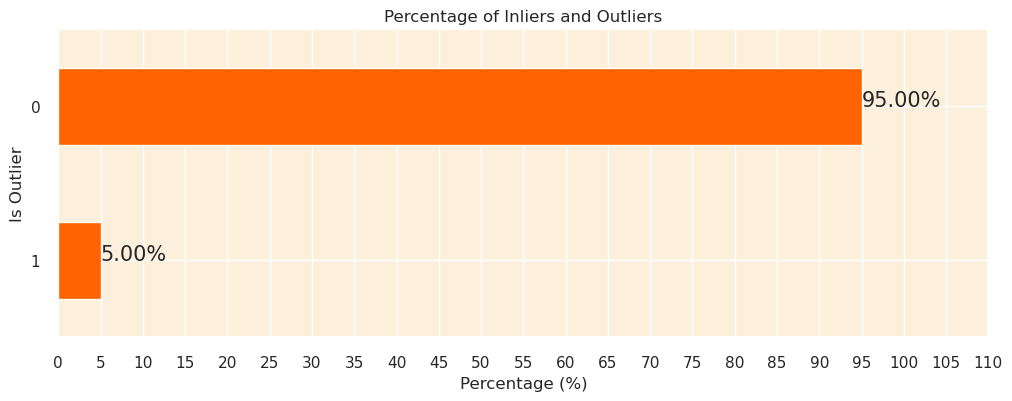

In [254]:
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [255]:
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

customer_data_cleaned.reset_index(drop=True, inplace=True)

In [256]:
customer_data_cleaned.shape[0]

1805

## Correlation analysis

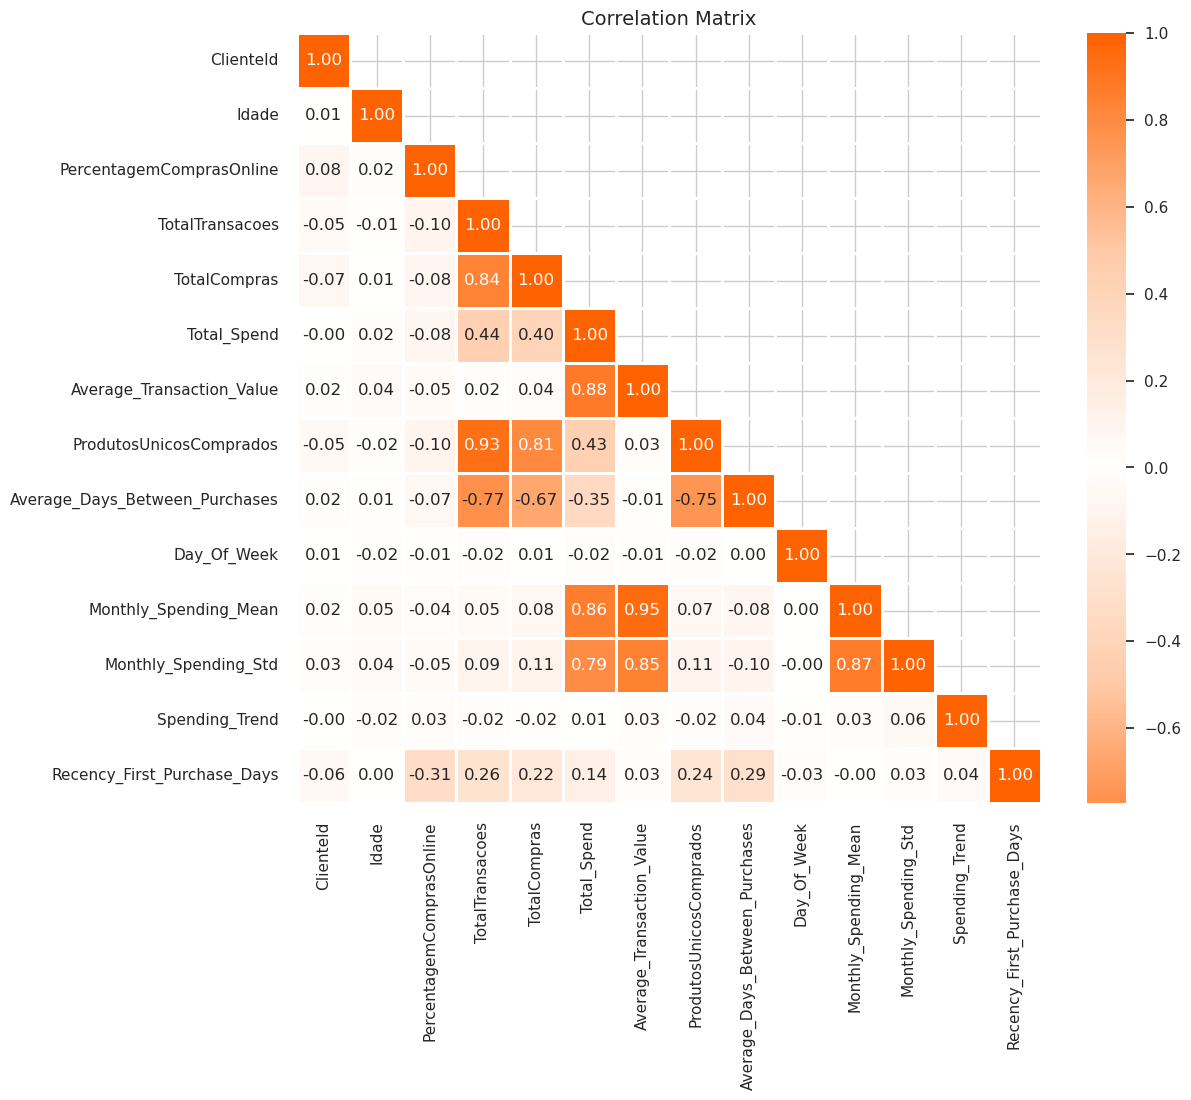

In [257]:
sns.set_style('whitegrid')

numeric_columns = customer_data_cleaned.select_dtypes(include=['number']).columns
numeric_columns = [col for col in numeric_columns if col != 'Hour']

corr = customer_data_cleaned[numeric_columns].corr()

colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

## Feature scaling

In [258]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['ClienteId', 'Day_Of_Week', 'Nome', 'Sexo', 'DataId', 'DataCompra', 'InvoiceDay', 'Favorite_Shopping_Day', 'Concelho', 'Distrito', 'DataNascimento', 'EstadoCivil', 'Profissão', 'CategoriaFavorita']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Recency_First_Purchase_Days,CategoriaFavorita
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20,-1.290512,-0.385102,...,2.216440,-1.199924,4,0.0,Friday,0.462912,1.145139,0.190523,0.310681,Perifericos
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20,-0.685067,1.346950,...,-0.068064,0.245788,1,0.0,Tuesday,-1.088685,-0.701503,-0.092908,0.326811,Perifericos
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20,-1.366192,0.047911,...,-1.337233,2.142055,3,0.0,Thursday,-0.362974,-0.017387,0.984313,0.542953,Componentes
3,103,Pilar Batista,Feminino,Casado,Professor,Guimarães,Braga,1972-02-11,0.979907,1.073468,...,0.439603,-0.195633,4,0.0,Friday,-0.802401,-0.574359,0.258485,0.275196,Smartphones
4,104,César Costa,Masculino,Casado,Arquiteto,Porto,Porto,1995-04-25,-0.760747,0.217351,...,0.439603,-0.928712,6,0.0,Sunday,1.100788,0.123932,-0.573472,-0.526462,Smartphones


## Dimensionality reduction

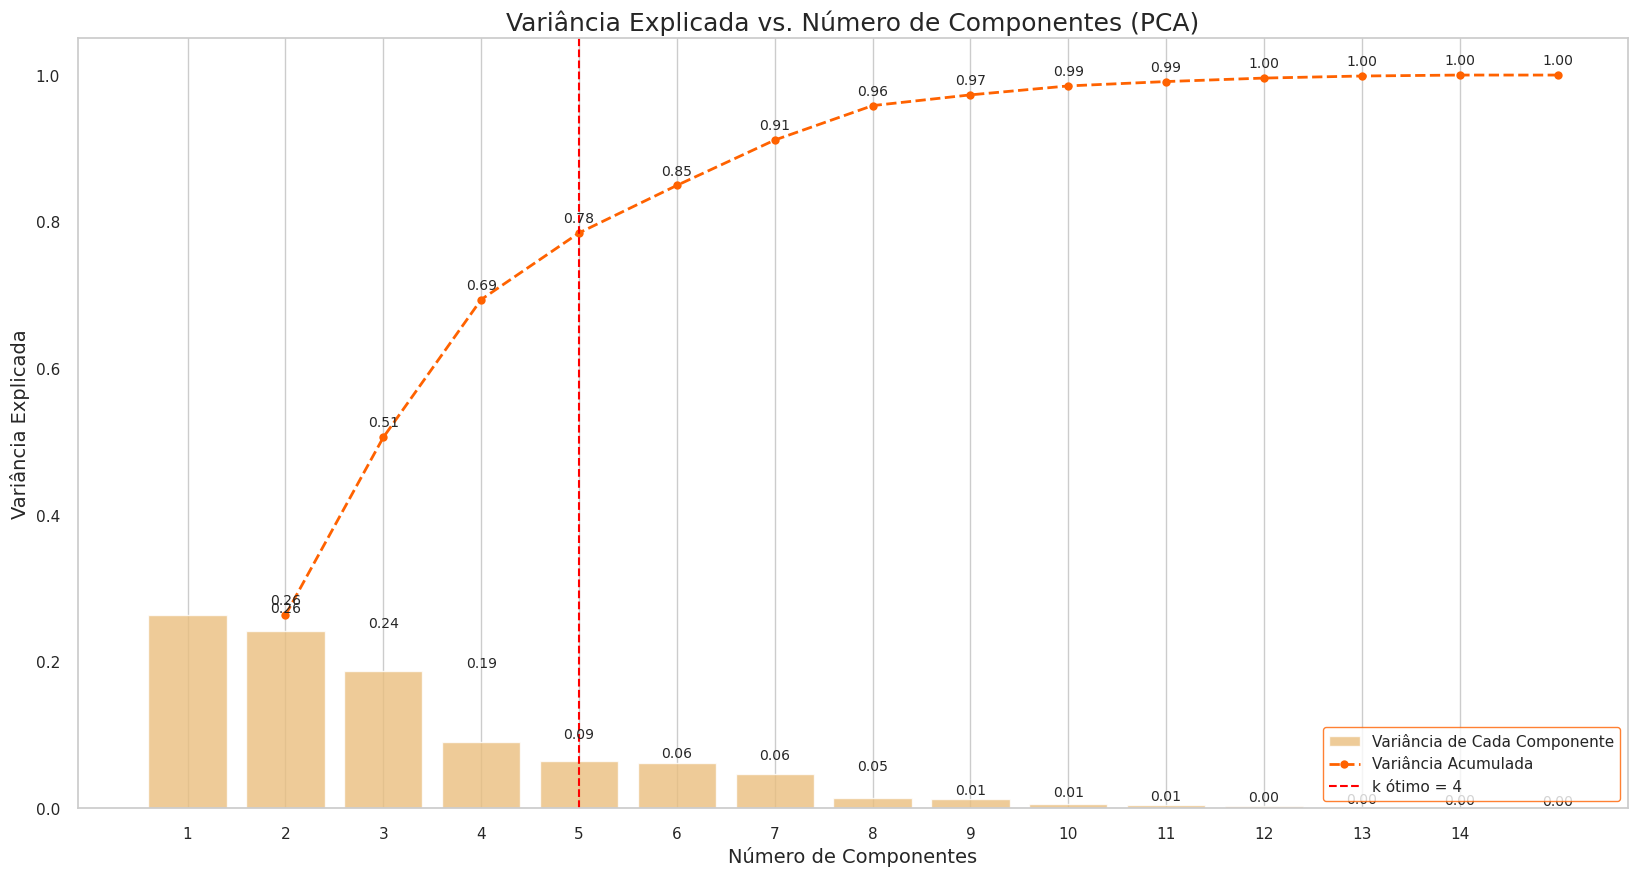

In [259]:
# Garantir que só usamos colunas numéricas
numeric_columns = customer_data_scaled.select_dtypes(include=['number']).columns
customer_data_numeric = customer_data_scaled[numeric_columns]

# Definir índice como ClienteId, se existir
if 'ClienteId' in customer_data_numeric.columns:
    customer_data_numeric.set_index('ClienteId', inplace=True)

# Substituir valores ausentes pela média
customer_data_numeric_imputed = customer_data_numeric.fillna(customer_data_numeric.mean())

# Aplicar PCA
pca = PCA().fit(customer_data_numeric_imputed)

# Variância explicada e cumulativa
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

optimal_k = 4

# Gráfico
plt.figure(figsize=(20, 10))

# Barras: variância explicada por componente
barplot = sns.barplot(
    x=list(range(1, len(explained_variance_ratio) + 1)),
    y=explained_variance_ratio,
    color='#fcc36d',
    alpha=0.8
)

# Linha: variância explicada acumulada
lineplot, = plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker='o', linestyle='--', color='#ff6200', linewidth=2
)

# Linha vertical para o número ótimo de clusters
optimal_k_line = plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')

# Títulos e eixos
plt.xlabel('Número de Componentes', fontsize=14)
plt.ylabel('Variância Explicada', fontsize=14)
plt.title('Variância Explicada vs. Número de Componentes (PCA)', fontsize=18)

# Legenda
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Variância de Cada Componente', 'Variância Acumulada', f'k ótimo = {optimal_k}'],
           loc='lower right',
           frameon=True,
           edgecolor='#ff6200')

# Anotar os valores nos gráficos
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i + 1, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    plt.text(i + 1, cum_ev_ratio + 0.01, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()


In [260]:
# Creating a PCA object with 6 components
pca = PCA(n_components=4)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_numeric_imputed)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_numeric_imputed.index

In [261]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4
ClienteId,,,,
100,3.451167,2.095235,-1.219451,0.226056
101,-1.507907,-1.794402,-1.002291,-0.431148
102,-2.782347,0.055927,1.974950,1.075253
103,-1.115398,1.303781,-1.580783,-0.405507
104,1.710302,3.860192,0.104094,-0.774860


In [262]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Garante que usas as mesmas colunas que foram usadas no PCA
features_used = customer_data_numeric_imputed.columns[:pca.components_.shape[1]]

pc_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=features_used
)

# Desta forma, aplica o estilo corretamente
pc_df.style.apply(highlight_top3, axis=0)


,PC1,PC2,PC3,PC4
Idade,0.014559,-0.008378,0.032588,-0.021744
PercentagemComprasOnline,-0.056990,-0.013822,0.016647,-0.579781
TotalTransacoes,0.349619,0.049046,-0.378500,0.041824
TotalCompras,0.328378,0.059715,-0.344223,0.036259
Total_Spend,0.440892,0.072309,0.200901,0.011400
Average_Transaction_Value,0.323852,0.058204,0.412507,-0.006969
ProdutosUnicosComprados,0.348291,0.049615,-0.367734,0.037083
Average_Days_Between_Purchases,-0.297000,-0.051877,0.322457,0.374600
Day_Of_Week,-0.165590,0.985746,-0.012581,0.013705
Hour,-0.000000,0.000000,-0.000000,-0.000000


## K-means clustering

### Nº optimo de clusters - Elbow method

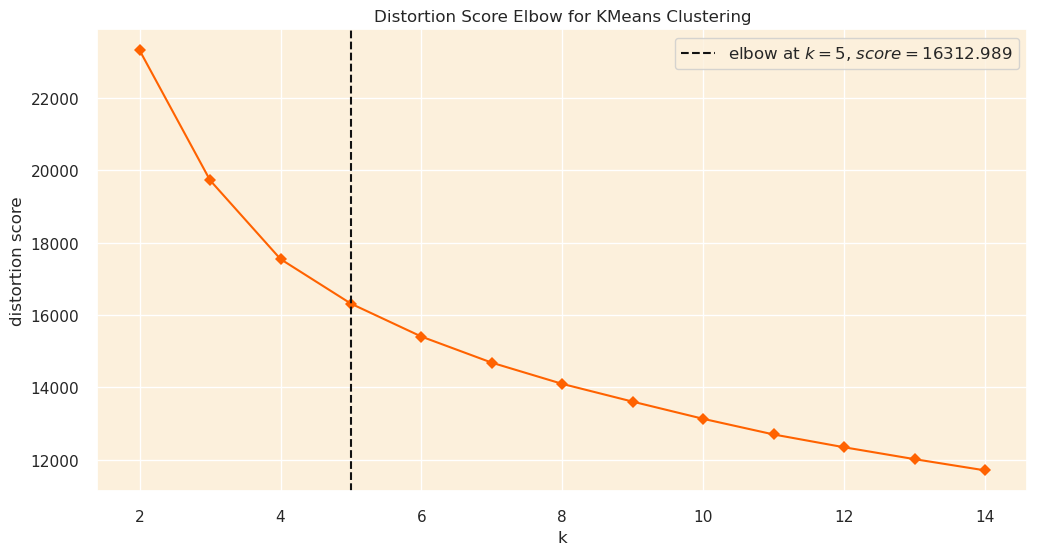

In [263]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 6))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_numeric_imputed)

# Finalize and render the figure
visualizer.show();

### Nº optimo de clusters - Silhouette method

In [264]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

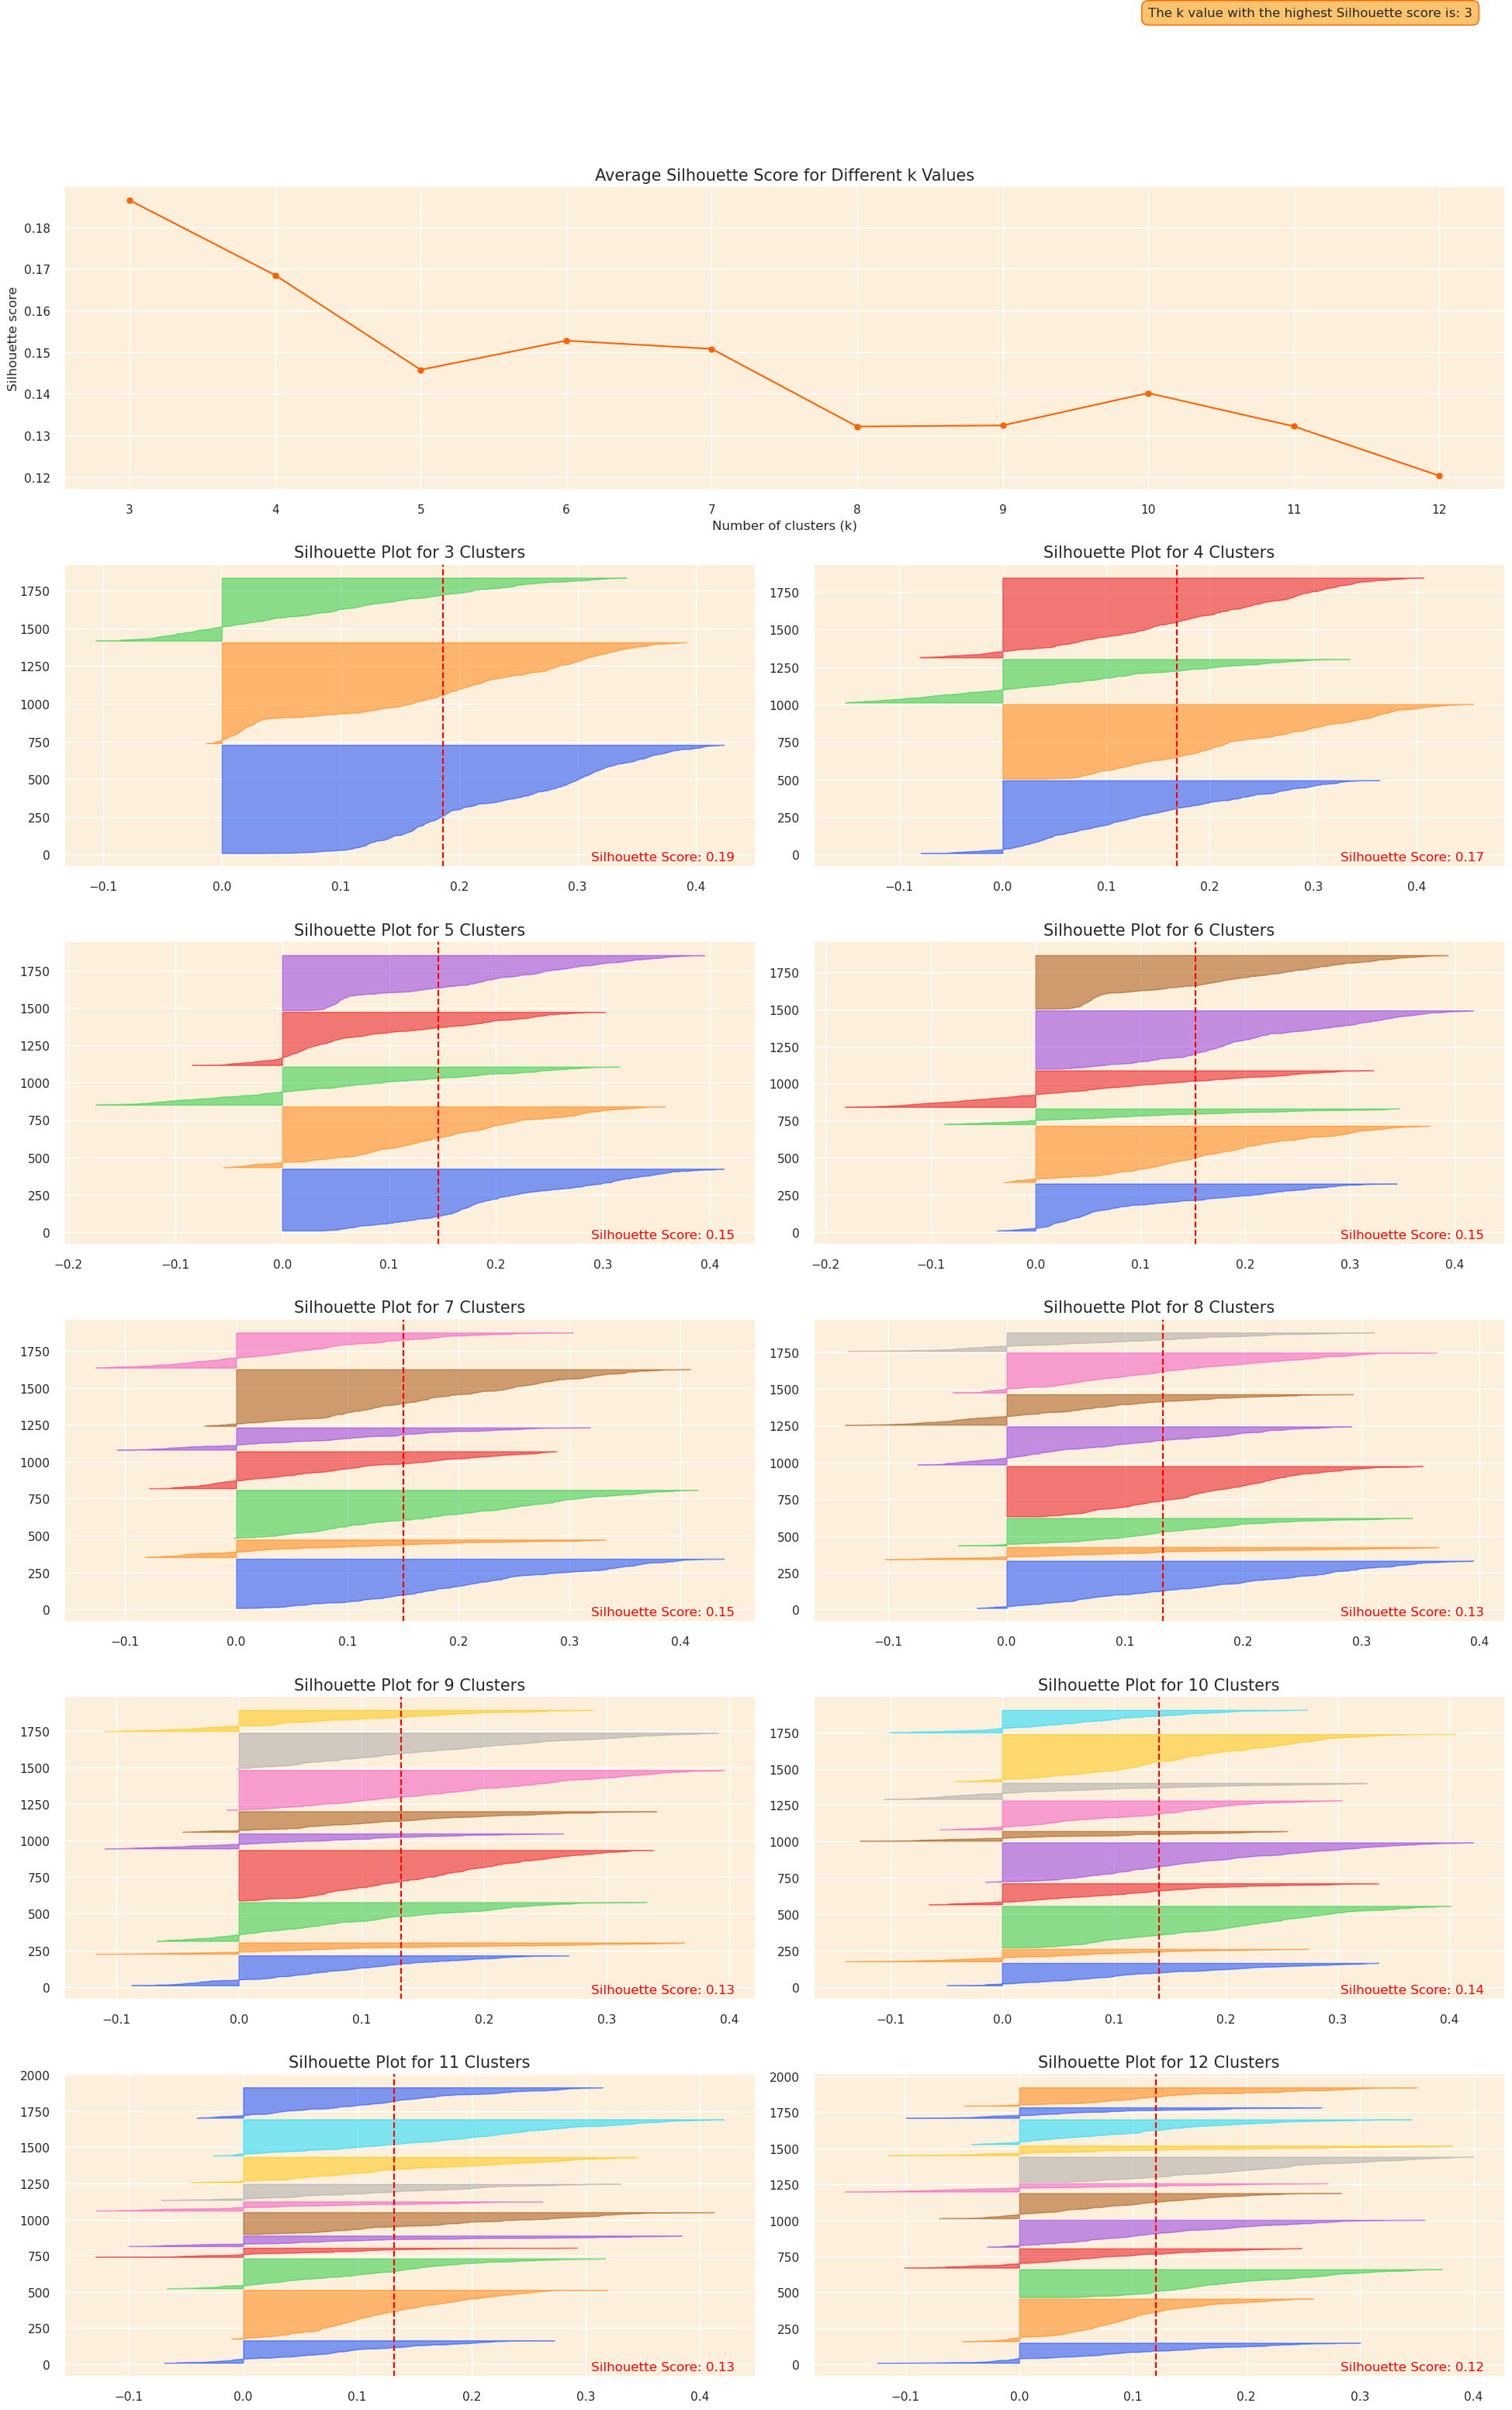

In [265]:
silhouette_analysis(customer_data_numeric_imputed, 3, 12, figsize=(20, 50))

### Clustering com k-means

In [266]:
# Apply KMeans clustering with 7 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_numeric_imputed)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency (most common becomes 0, etc.)
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [267]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Recency_First_Purchase_Days,CategoriaFavorita,cluster
0,100,Erika Simões,Feminino,Solteiro,Estudante,Barcelos,Braga,2001-08-20,23,44.444444,...,187.346154,4,12,Friday,288.333719,502.49089,6.800584,5182,Perifericos,3
1,101,Carminho Reis,Feminino,Solteiro,Comerciante,Estremoz,Évora,1993-10-20,31,66.666667,...,298.411765,1,12,Tuesday,109.746436,149.995418,-1.22336,5192,Perifericos,2
2,102,Bruno de Fernandes,Masculino,Solteiro,Gestor de Projetos,Montemor-o-Novo,Évora,2003-02-20,22,50.0,...,444.090909,3,12,Thursday,193.27504,280.582672,29.272781,5326,Componentes,2
3,103,Pilar Batista,Feminino,Casado,Professor,Guimarães,Braga,1972-02-11,53,63.157895,...,264.5,4,12,Friday,142.697464,174.265272,8.724591,5160,Smartphones,0
4,104,César Costa,Masculino,Casado,Arquiteto,Porto,Porto,1995-04-25,30,52.173913,...,208.181818,6,12,Sunday,361.752625,307.558336,-14.828133,4663,Smartphones,0


## Avaliação dos clusters

In [268]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff', '#ff6200']

In [269]:
fig = go.Figure()

for i in range(4):
    cluster_data = customer_data_pca[customer_data_pca['cluster'] == i]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['PC1'], 
        y=cluster_data['PC2'], 
        z=cluster_data['PC3'],
        mode='markers',
        marker=dict(color=colors[i], size=5, opacity=0.4),
        name=f'Cluster {i}'
    ))

fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

fig.show()

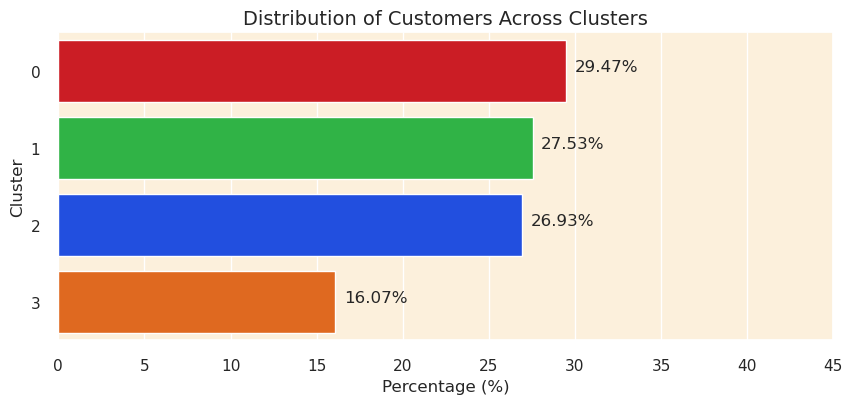

In [270]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

In [271]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        1805        |
|    Silhouette Score     | 0.2369111681036702 |
| Calinski Harabasz Score | 582.0923063074237  |
|  Davies Bouldin Score   | 1.2489356279039239 |
+-------------------------+--------------------+


## Profiling

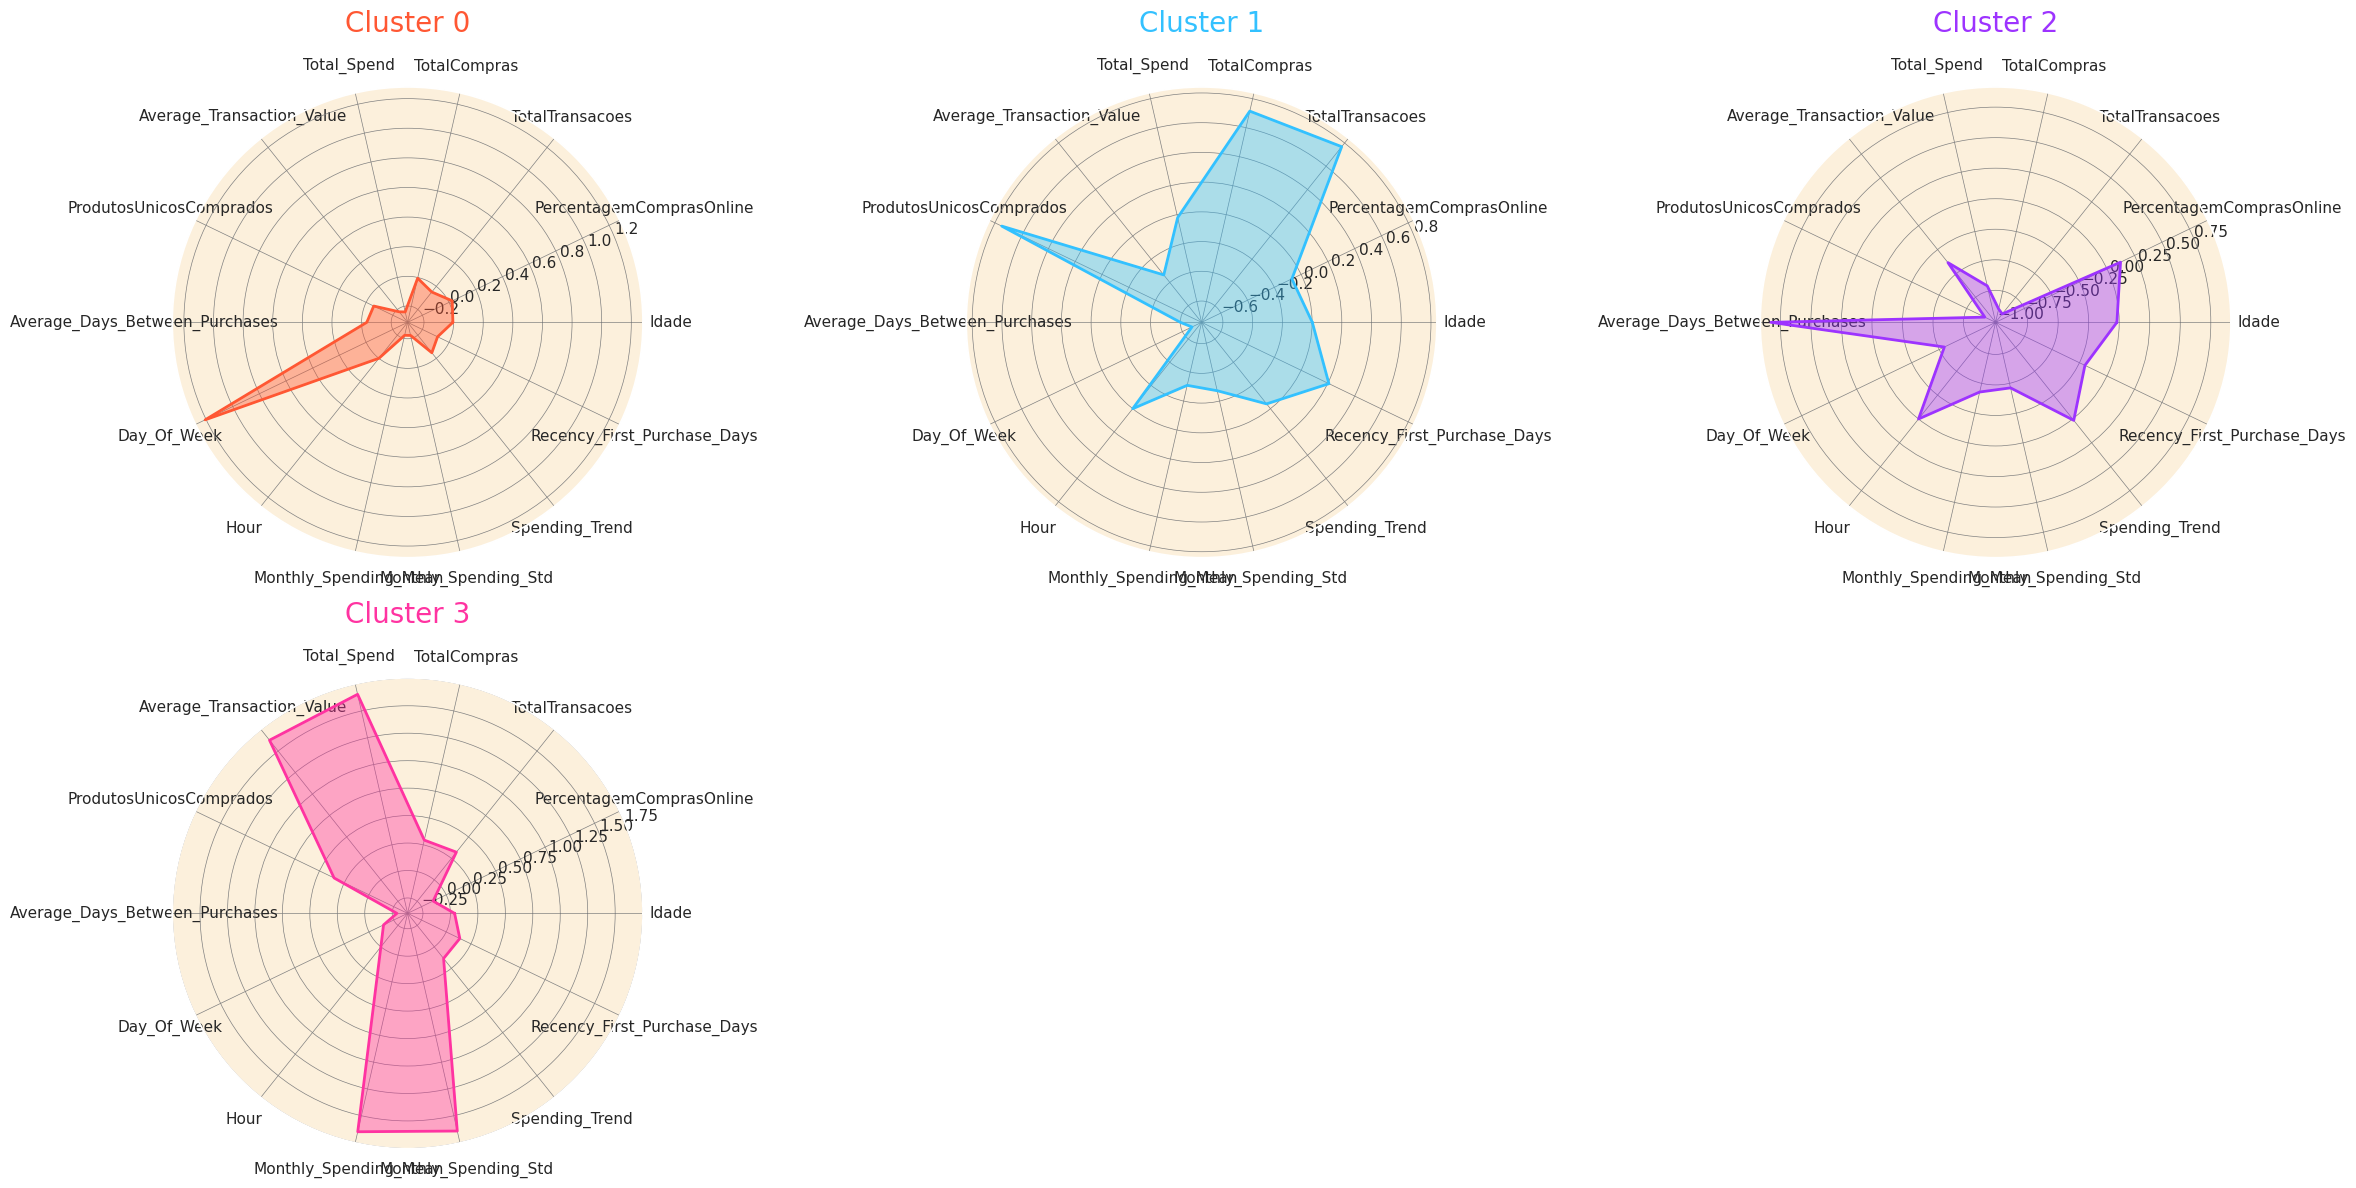

In [300]:
df_customer = customer_data_cleaned.set_index('ClienteId')

# Keep only numeric columns for scaling (excluding 'cluster')
numeric_cols = df_customer.select_dtypes(include=np.number).drop(columns=['cluster'])

# Standardize the numeric data
scaler = StandardScaler()
standardized_values = scaler.fit_transform(numeric_cols)

# Create a DataFrame with standardized values
df_customer_standardized = pd.DataFrame(
    standardized_values,
    columns=numeric_cols.columns,
    index=df_customer.index
)

# Add the 'cluster' column back
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot and fill
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Labels and number of variables
labels = np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angles for radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop for circular radar
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

colors = ['#FF5733', '#33C1FF', '#9D33FF', '#FF33A1'] 

n_clusters = 4
nrows = 2
ncols = 3

fig, axs = plt.subplots(figsize=(8 * ncols, 6 * nrows), 
                        subplot_kw=dict(polar=True), 
                        nrows=nrows, 
                        ncols=ncols)

axs = axs.flatten() 

for i in range(n_clusters):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]
    create_radar_chart(axs[i], angles, data, colors[i], i)

    axs[i].set_xticks(angles[:-1])
    axs[i].set_xticklabels(labels[:-1])
    axs[i].grid(color='grey', linewidth=0.5)

for j in range(n_clusters, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


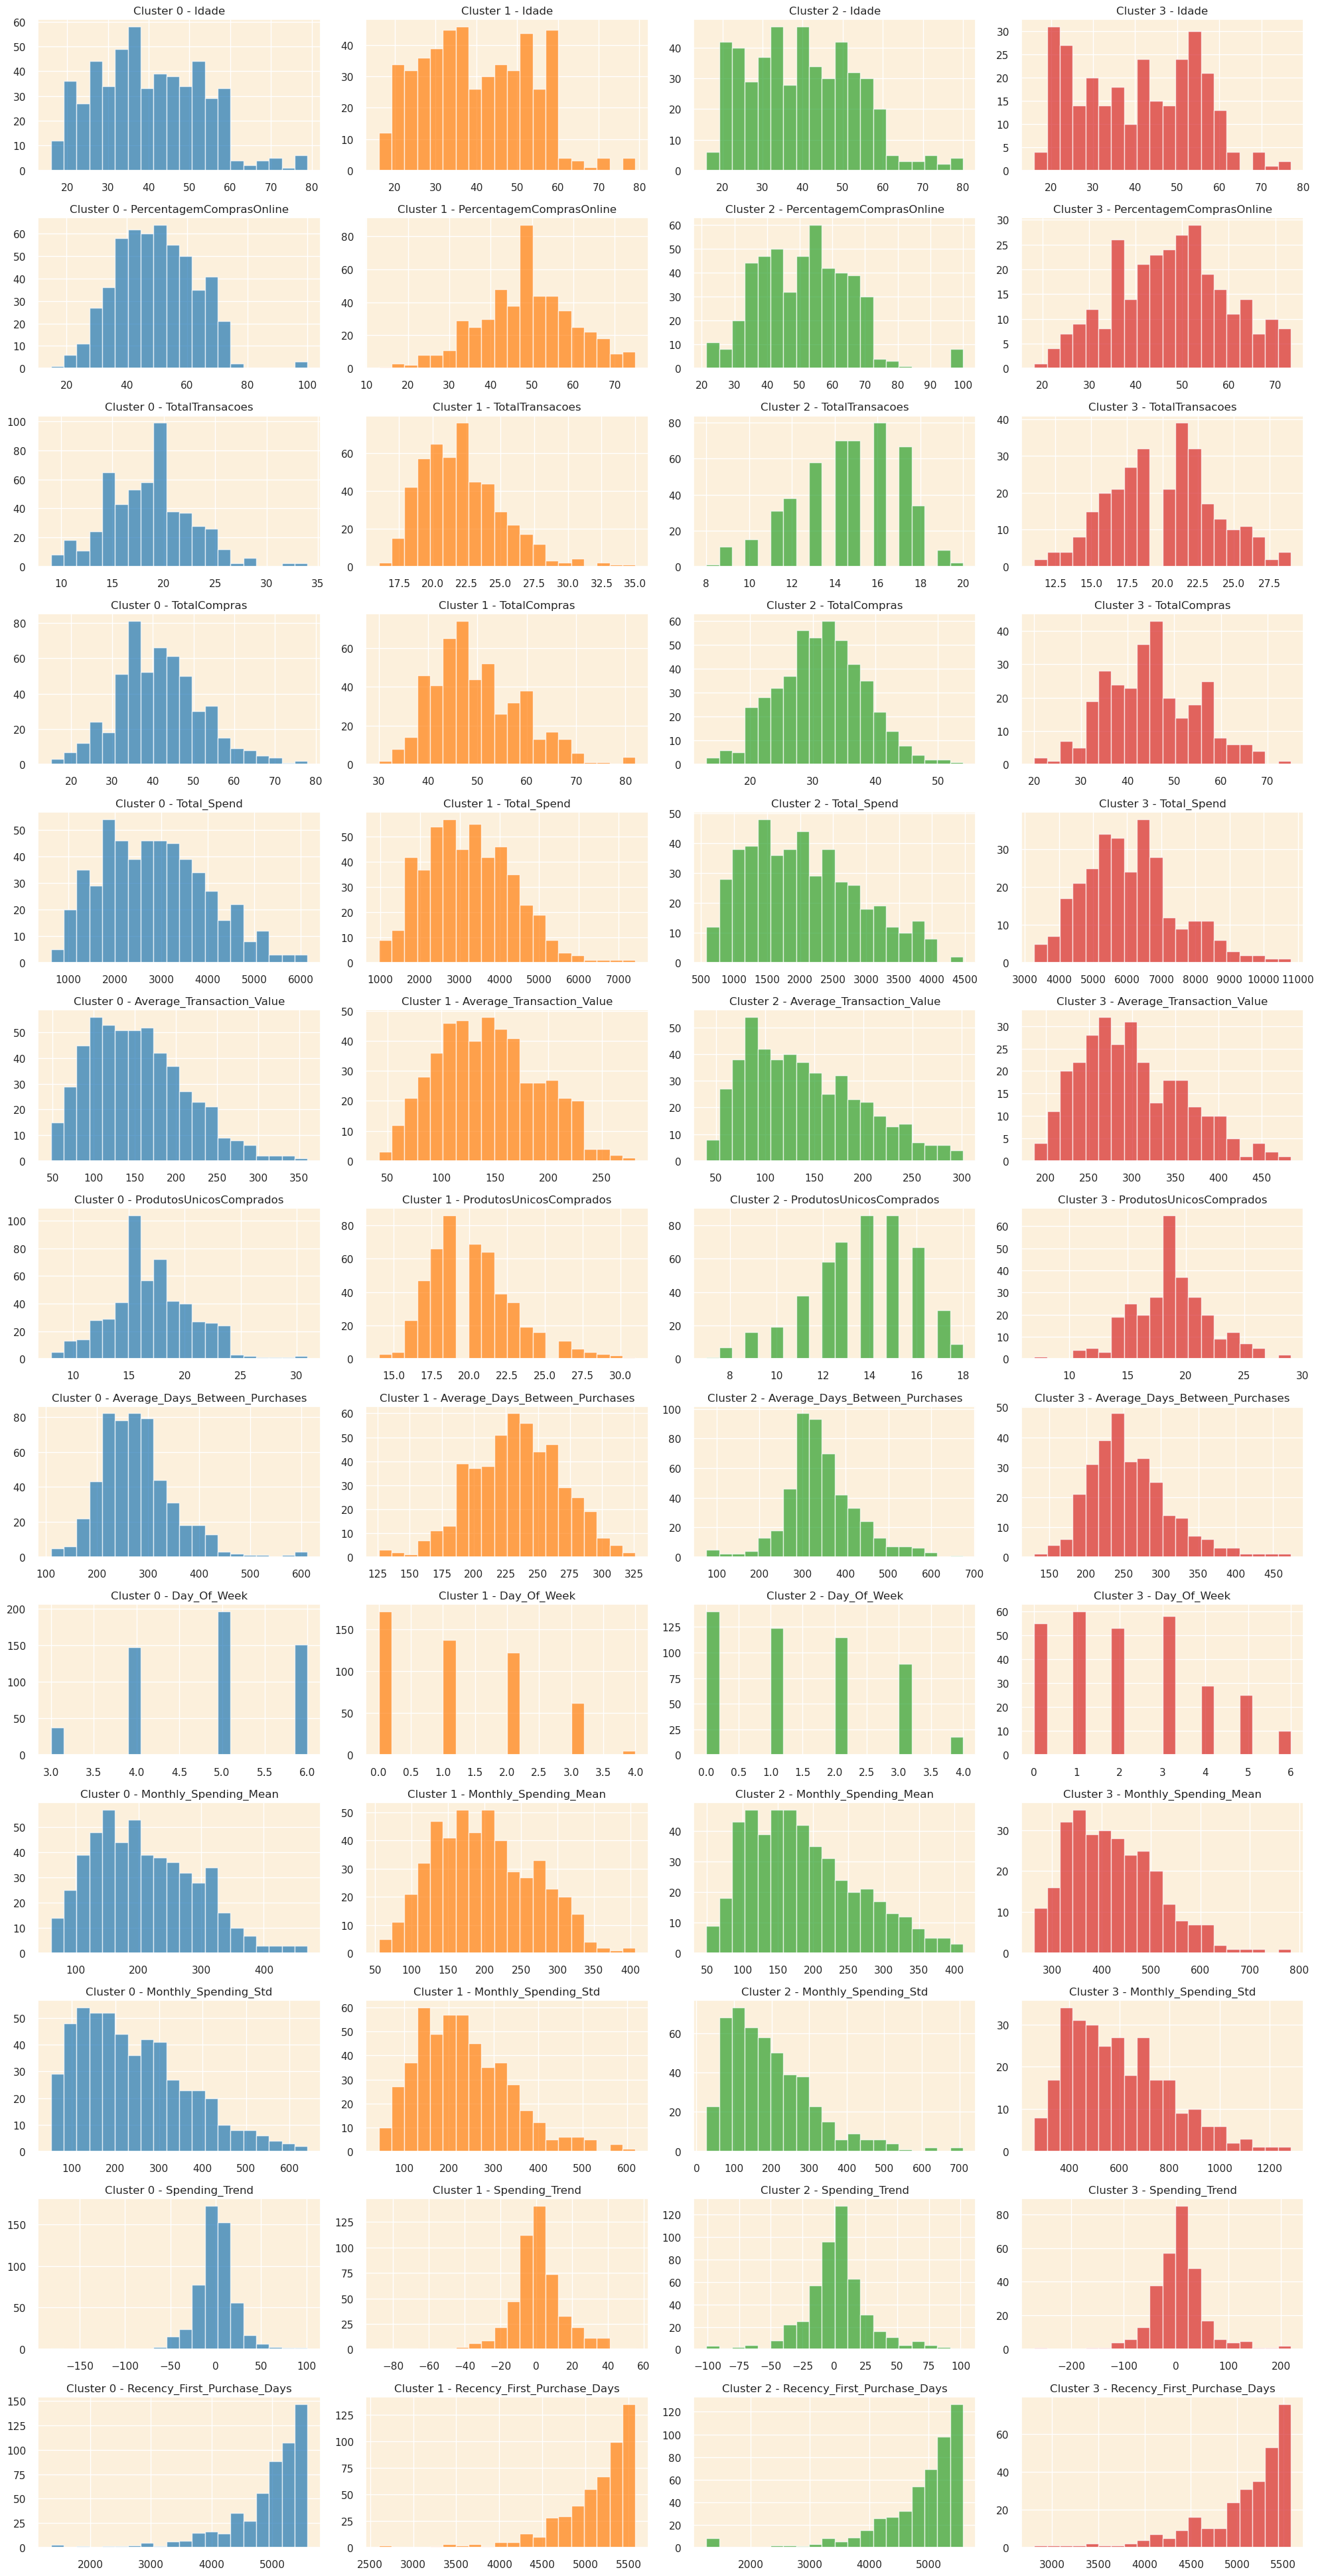

In [273]:
import matplotlib.cm as cm
import numpy as np

features = customer_data_cleaned.drop(
    columns=['ClienteId', 'cluster', 'Nome', 'Sexo', 'EstadoCivil', 'Profissão', 'Concelho', 'Distrito', 'DataNascimento', 'Favorite_Shopping_Day', 'CategoriaFavorita', 'Hour']
).columns

clusters = np.sort(customer_data_cleaned['cluster'].unique())
n_clusters = len(clusters)

# Setup color palette
colors = cm.tab10.colors[:n_clusters]

# Setup subplots
n_rows = len(features)
n_cols = n_clusters
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))
axes = np.atleast_2d(axes)  # Ensure 2D indexing works

# Plot histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]

        # Handle data types
        if pd.api.types.is_bool_dtype(data):
            data_clean = data.dropna().astype(int)  # Convert bool to 0/1
        elif pd.api.types.is_numeric_dtype(data):
            data_clean = data.dropna()
        else:
            data_clean = None

        # Plot or show message
        if data_clean is not None and len(data_clean) > 0:
            axes[i, j].hist(data_clean, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        elif data_clean is not None:
            axes[i, j].text(0.5, 0.5, "No valid data", 
                            horizontalalignment='center',
                            verticalalignment='center',
                            transform=axes[i, j].transAxes)
        else:
            axes[i, j].text(0.5, 0.5, f"Non-numeric feature: {feature}", 
                            horizontalalignment='center',
                            verticalalignment='center',
                            transform=axes[i, j].transAxes)

        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=12)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

plt.tight_layout()
plt.show()


# **Sistemas de recomendação**

## Demographic filetering
Recomendação da trend de vendas para clientes novos sem dados

In [274]:
# Determinar a data da compra mais antiga
df_vendas['DataId'] = pd.to_datetime(df_vendas['DataId'])

data_compra_mais_antiga = df_vendas['DataId'].min()

print(f"A compra mais antiga foi em: {data_compra_mais_antiga.date()}")

A compra mais antiga foi em: 2010-01-01


In [275]:
hoje = datetime.now()
um_mes_atras = hoje - timedelta(days=365)

vendas_ultimo_mes = df_vendas[df_vendas['DataId'] >= um_mes_atras]

contagem_produtos = vendas_ultimo_mes['ProdutoId'].value_counts().reset_index()
contagem_produtos.columns = ['ProdutoId', 'NumeroVendas']

top_produtos = contagem_produtos.merge(df_produtos, on='ProdutoId', how='left')

top_30_produtos = top_produtos.head(30)

top_30_produtos


,ProdutoId,NumeroVendas,Nome,Marca,Categoria
0,137,84,Placa Gráfica ASUS TUF RTX 3090,ASUS,Componentes
1,89,83,Impressora Canon PIXMA G6020,Canon,Impressoras
2,119,82,Impressora HP LaserJet Pro M15w,HP,Impressoras
3,87,82,Placa Gráfica MSI RTX 3080,MSI,Componentes
4,67,82,Placa Gráfica NVIDIA RTX 3060,NVIDIA,Componentes
5,139,80,Impressora Epson WorkForce WF-110,Epson,Impressoras
6,104,79,Impressora Brother HL-L2350DW,Brother,Impressoras
7,72,79,Placa Gráfica ASUS RTX 3070,ASUS,Componentes
8,74,79,Impressora Epson EcoTank L3150,Epson,Impressoras
9,102,75,Placa Gráfica Gigabyte RTX 3060 Ti,Gigabyte,Componentes


## Content-based filtering + Collaborative filtering
Recomendações para clientes existentes com algum histórico de comprar <br>
Basear as recomendações em hábitos de compra do cliente e hábitos de compra do cluster onde o cliente está inserido

### Content-based filtering

In [276]:
# historico de compras de um dado cliente
def get_client_purchases(client_id, vendas_df):
    client_purchases = vendas_df[vendas_df['ClienteId'] == client_id]['ProdutoId'].unique()
    return client_purchases

In [277]:
from sklearn.metrics.pairwise import cosine_similarity

# recomendar produtos
def recommend_products(client_id, vendas_df, produtos_df, top_n=10):
    # Get the client's purchase history
    purchased_products = get_client_purchases(client_id, vendas_df)
    
    if len(purchased_products) == 0:
        return "No purchase history for this client."
    
    # Create one-hot encoding for product categories and brands
    produtos_encoded = pd.get_dummies(produtos_df[['Categoria', 'Marca']])
    
    # Calculate the profile of purchased products
    client_profile = produtos_encoded.loc[produtos_df['ProdutoId'].isin(purchased_products)].mean(axis=0)
    
    # Calculate similarity between client profile and all products
    similarity_scores = []
    for idx, row in produtos_encoded.iterrows():
        sim_score = cosine_similarity([client_profile], [row])[0][0]
        similarity_scores.append((produtos_df.loc[idx, 'ProdutoId'], produtos_df.loc[idx, 'Nome'], sim_score))
    
    # Sort by similarity and filter out already purchased products
    similarity_scores.sort(key=lambda x: x[2], reverse=True)
    recommendations = [(prod_id, name) for prod_id, name, _ in similarity_scores 
                      if prod_id not in purchased_products]
    
    return recommendations[:top_n]

In [278]:
example_customer_id = customer_data_cleaned['ClienteId'].iloc[0]
recomendations = recommend_products(example_customer_id, df_vendas, df_produtos, top_n=10)

print(f"\n----- CONTENT-BASED RECOMMENDATIONS FOR CLIENT {example_customer_id} -----")

df_recommendations = pd.DataFrame(recomendations, columns=['ProdutoId', 'Nome'])
display(df_recommendations)


----- CONTENT-BASED RECOMMENDATIONS FOR CLIENT 100 -----


,ProdutoId,Nome
0,1,Rato Logitech MX Master
1,12,Teclado Logitech G Pro
2,27,Teclado Logitech MX Keys
3,31,Rato Logitech G502
4,36,Rato Logitech G203
5,52,Teclado Logitech K380
6,61,Rato Logitech G305
7,92,Teclado Logitech Craft
8,111,Rato Logitech G703
9,116,Webcam Logitech Brio


### Collaborative filtering

In [279]:
df_with_clusters = df_vendas.merge(customer_data_cleaned[['ClienteId', 'cluster']], on='ClienteId', how='inner')

# Create a product purchase matrix: customers x products with purchase frequency
purchase_matrix = pd.crosstab(df_with_clusters['ClienteId'], df_with_clusters['ProdutoId'])

# Let's analyze product popularity by cluster
cluster_product_popularity = {}

for cluster_id in range(7):
    # Get customers in this cluster
    cluster_customers = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster_id]['ClienteId']
    
    # Filter transactions for this cluster
    cluster_transactions = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    
    # Calculate product popularity within this cluster
    product_counts = cluster_transactions.groupby('ProdutoId').agg(
        purchase_count=('VendaId', 'nunique'),
        customer_count=('ClienteId', 'nunique'),
        total_quantity=('Quantidade', 'sum'),
        total_revenue=('Total_Spend', 'sum')
    )
    
    # Calculate penetration rate (% of cluster customers who bought this product)
    cluster_customer_count = cluster_customers.nunique()
    product_counts['penetration_rate'] = product_counts['customer_count'] / cluster_customer_count * 100
    
    # Sort by popularity metrics
    popular_products = product_counts.sort_values(by=['penetration_rate', 'total_revenue'], ascending=False)
    
    # Store the results
    cluster_product_popularity[cluster_id] = popular_products

In [280]:
df_vendas = pd.merge(df_vendas, df_produtos, on='ProdutoId')

In [281]:
# Function to get top product recommendations for each cluster
def get_cluster_recommendations(cluster_id, top_n=10):
    popular_products = cluster_product_popularity[cluster_id].head(top_n)
    
    # Get product descriptions
    product_info = df_vendas[['ProdutoId', 'Nome']].drop_duplicates()
    recommendations = popular_products.reset_index().merge(
        product_info, on='ProdutoId', how='left'
    )
    
    return recommendations[['ProdutoId', 'Nome', 'purchase_count', 
                           'customer_count', 'penetration_rate', 
                           'total_quantity', 'total_revenue']]

In [289]:
for cluster_id in range(4):
    print(f"\n----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER {cluster_id} -----")
    cluster_recs = get_cluster_recommendations(cluster_id, top_n=10)

    cluster_recs['penetration_rate'] = cluster_recs['penetration_rate'].map('{:.2f}'.format)
    cluster_recs['total_revenue'] = cluster_recs['total_revenue'].map('{:.2f}'.format)

    display(cluster_recs.reset_index(drop=True))


----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 0 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,87,Placa Gráfica MSI RTX 3080,236,189,35.53,498,38383.66
1,137,Placa Gráfica ASUS TUF RTX 3090,232,184,34.59,537,36004.15
2,74,Impressora Epson EcoTank L3150,236,180,33.83,516,32645.58
3,89,Impressora Canon PIXMA G6020,224,179,33.65,500,34226.65
4,139,Impressora Epson WorkForce WF-110,213,176,33.08,473,35138.29
5,104,Impressora Brother HL-L2350DW,221,175,32.89,483,35089.14
6,67,Placa Gráfica NVIDIA RTX 3060,210,175,32.89,448,34239.24
7,102,Placa Gráfica Gigabyte RTX 3060 Ti,228,174,32.71,478,38224.24
8,69,Impressora HP DeskJet 2720,220,170,31.95,500,34865.16
9,72,Placa Gráfica ASUS RTX 3070,216,166,31.20,533,36696.48



----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 1 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,117,Placa Gráfica NVIDIA GTX 1660 Super,257,197,39.64,598,31440.68
1,67,Placa Gráfica NVIDIA RTX 3060,253,196,39.44,574,37928.56
2,87,Placa Gráfica MSI RTX 3080,257,194,39.03,546,39453.05
3,104,Impressora Brother HL-L2350DW,240,191,38.43,508,29495.50
4,102,Placa Gráfica Gigabyte RTX 3060 Ti,229,182,36.62,465,31657.93
5,139,Impressora Epson WorkForce WF-110,228,181,36.42,525,33001.99
6,119,Impressora HP LaserJet Pro M15w,235,180,36.22,521,37787.16
7,69,Impressora HP DeskJet 2720,226,178,35.81,520,33032.57
8,74,Impressora Epson EcoTank L3150,211,168,33.80,437,30170.81
9,72,Placa Gráfica ASUS RTX 3070,210,166,33.40,482,33749.13



----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 2 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,69,Impressora HP DeskJet 2720,169,135,27.78,339,23509.64
1,87,Placa Gráfica MSI RTX 3080,170,135,27.78,345,20219.39
2,89,Impressora Canon PIXMA G6020,168,133,27.37,330,24497.89
3,137,Placa Gráfica ASUS TUF RTX 3090,160,132,27.16,329,23837.88
4,104,Impressora Brother HL-L2350DW,154,132,27.16,333,23361.68
5,102,Placa Gráfica Gigabyte RTX 3060 Ti,161,130,26.75,339,17586.44
6,119,Impressora HP LaserJet Pro M15w,149,128,26.34,307,18572.65
7,74,Impressora Epson EcoTank L3150,159,127,26.13,303,24387.89
8,72,Placa Gráfica ASUS RTX 3070,150,127,26.13,327,23625.11
9,67,Placa Gráfica NVIDIA RTX 3060,157,127,26.13,313,20607.17



----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 3 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,117,Placa Gráfica NVIDIA GTX 1660 Super,150,108,37.24,319,47141.65
1,102,Placa Gráfica Gigabyte RTX 3060 Ti,139,107,36.90,299,43226.42
2,119,Impressora HP LaserJet Pro M15w,126,103,35.52,274,38903.03
3,69,Impressora HP DeskJet 2720,126,100,34.48,278,43849.87
4,139,Impressora Epson WorkForce WF-110,119,98,33.79,256,40041.06
5,72,Placa Gráfica ASUS RTX 3070,124,94,32.41,262,36798.38
6,67,Placa Gráfica NVIDIA RTX 3060,122,92,31.72,275,39638.79
7,137,Placa Gráfica ASUS TUF RTX 3090,117,90,31.03,235,32375.74
8,87,Placa Gráfica MSI RTX 3080,114,88,30.34,245,27798.00
9,89,Impressora Canon PIXMA G6020,114,86,29.66,221,26785.74


In [290]:
def get_customer_recommendations(customer_id, n_recommendations=5):
    try:
        customer_cluster = customer_data_cleaned[
            customer_data_cleaned['ClienteId'] == customer_id
        ]['cluster'].values[0]
    except IndexError:
        return "Customer not found in the cluster data."

    # Verifica se o cluster existe no dicionário
    if customer_cluster not in cluster_product_popularity:
        return f"No product popularity data for cluster {customer_cluster}."

    customer_purchases = df_vendas[df_vendas['ClienteId'] == customer_id]['ProdutoId'].unique()
    cluster_popular = cluster_product_popularity[customer_cluster]

    new_recommendations = cluster_popular[
        ~cluster_popular.index.isin(customer_purchases)
    ].head(n_recommendations)

    product_info = df_vendas[['ProdutoId', 'Nome']].drop_duplicates()
    recommendations = new_recommendations.reset_index().merge(
        product_info, on='ProdutoId', how='left'
    )

    return recommendations[['ProdutoId', 'Nome', 'penetration_rate', 'total_revenue']]


In [284]:
print(f"\n----- PERSONALIZED RECOMMENDATIONS FOR CUSTOMER {example_customer_id} -----")
customer_recs = get_customer_recommendations(example_customer_id, n_recommendations=10)

# Verifica se o retorno é um DataFrame
if isinstance(customer_recs, pd.DataFrame) and not customer_recs.empty:
    customer_recs['penetration_rate'] = customer_recs['penetration_rate'].map('{:.2f}'.format)
    customer_recs['total_revenue'] = customer_recs['total_revenue'].map('{:.2f}'.format)
    display(customer_recs.reset_index(drop=True))
else:
    print(customer_recs)  # Mostra mensagem_


----- PERSONALIZED RECOMMENDATIONS FOR CUSTOMER 100 -----


,ProdutoId,Nome,penetration_rate,total_revenue
0,117,Placa Gráfica NVIDIA GTX 1660 Super,37.24,47141.65
1,102,Placa Gráfica Gigabyte RTX 3060 Ti,36.90,43226.42
2,119,Impressora HP LaserJet Pro M15w,35.52,38903.03
3,69,Impressora HP DeskJet 2720,34.48,43849.87
4,67,Placa Gráfica NVIDIA RTX 3060,31.72,39638.79
5,137,Placa Gráfica ASUS TUF RTX 3090,31.03,32375.74
6,87,Placa Gráfica MSI RTX 3080,30.34,27798.00
7,89,Impressora Canon PIXMA G6020,29.66,26785.74
8,104,Impressora Brother HL-L2350DW,28.97,27849.73
9,108,"Monitor 27 Dell Alienware""",19.31,15220.96



----- PRODUCTS WITH UNIVERSAL APPEAL ACROSS ALL CLUSTERS -----
No products with universal appeal found.


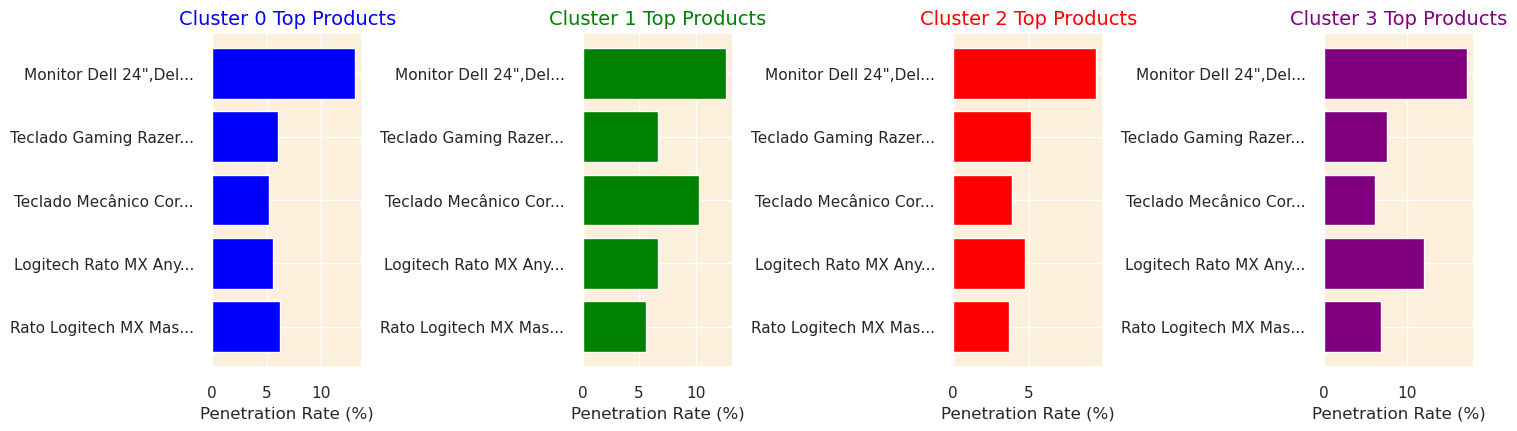

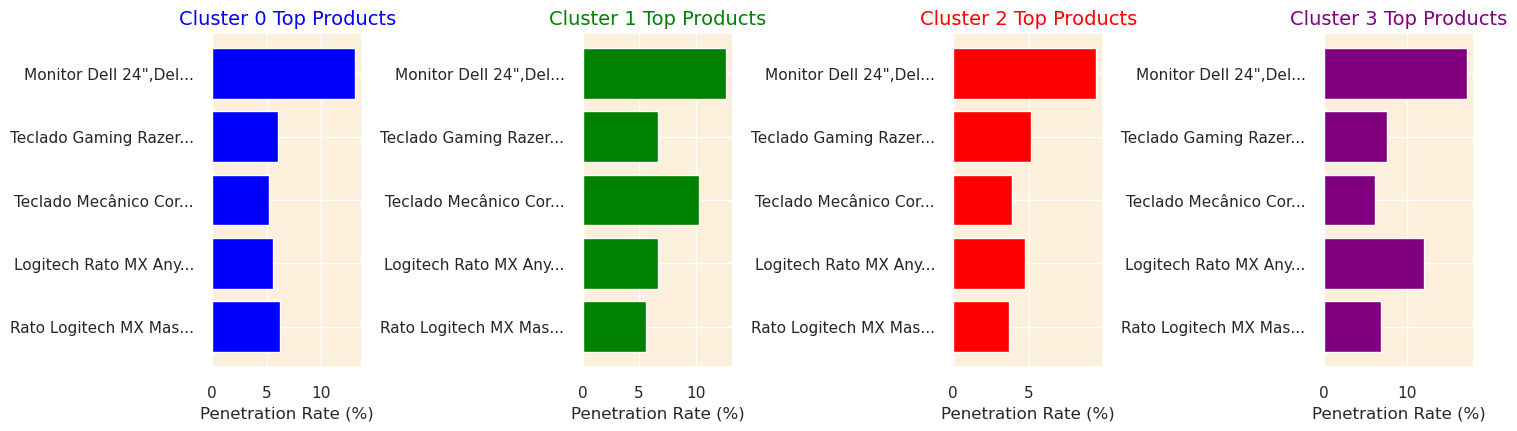


----- CLUSTER PROFILES FOR MARKETING RECOMMENDATIONS -----

CLUSTER 0 PROFILE:
Size: 532 customers (29.47% of total)
Average transactions per customer: 18.38
Average total spend: $2850.94
Average transaction value: $153.07
Average Age: 39.99
Average online purchases percentage: 49.69
Top product categories:
  - Placa Gráfica MSI RTX 3080 (Penetration: 35.53%)
  - Placa Gráfica ASUS TUF RTX 3090 (Penetration: 34.59%)
  - Impressora Epson EcoTank L3150 (Penetration: 33.83%)

CLUSTER 1 PROFILE:
Size: 497 customers (27.53% of total)
Average transactions per customer: 21.94
Average total spend: $3223.92
Average transaction value: $143.90
Average Age: 40.07
Average online purchases percentage: 48.50
Top product categories:
  - Placa Gráfica NVIDIA GTX 1660 Super (Penetration: 39.64%)
  - Placa Gráfica NVIDIA RTX 3060 (Penetration: 39.44%)
  - Placa Gráfica MSI RTX 3080 (Penetration: 39.03%)

CLUSTER 2 PROFILE:
Size: 486 customers (26.93% of total)
Average transactions per customer: 14.57
Av

In [293]:
# Vamos analisar as recomendações de produtos entre clusters
# Isso ajudará a identificar produtos populares em vários clusters
# e que poderiam ser bons candidatos para promoções gerais.

# Calcular a popularidade dos produtos em todos os clusters
all_product_stats = df_with_clusters.groupby('ProdutoId').agg(
    purchase_count=('VendaId', 'nunique'),
    customer_count=('ClienteId', 'nunique'),
    total_quantity=('Quantidade', 'sum'),
    total_revenue=('Total_Spend', 'sum')
)

# Calcular a popularidade dentro de cada cluster
cluster_product_matrix = {}
for cluster_id in range(4):
    cluster_txns = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    
    product_stats = cluster_txns.groupby('ProdutoId').agg(
        customer_count=('ClienteId', 'nunique')
    )
    
    cluster_size = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster_id].shape[0]
    product_stats[f'cluster_{cluster_id}_penetration'] = product_stats['customer_count'] / cluster_size * 100
    
    cluster_product_matrix[cluster_id] = product_stats

# Combinar as estatísticas específicas dos clusters
cross_cluster_stats = all_product_stats.copy()
for cluster_id in range(4):
    cross_cluster_stats = cross_cluster_stats.join(
        cluster_product_matrix[cluster_id][f'cluster_{cluster_id}_penetration'],
        how='left'
    )

# Calcular a variância da penetração entre clusters para encontrar produtos com apelo universal
cross_cluster_stats['penetration_variance'] = cross_cluster_stats[[
    f'cluster_{i}_penetration' for i in range(4)
]].var(axis=1)

# Preencher valores NaN (produtos não comprados em alguns clusters)
cross_cluster_stats = cross_cluster_stats.fillna(0)

# Identificar produtos com alta penetração em múltiplos clusters (apelo universal)
universal_products = cross_cluster_stats[
    (cross_cluster_stats['penetration_variance'] < cross_cluster_stats['penetration_variance'].quantile(0.25)) &
    (cross_cluster_stats[[f'cluster_{i}_penetration' for i in range(4)]] > 0).sum(axis=1) == 7
].sort_values(by='total_revenue', ascending=False)

# Obter descrições para os produtos com apelo universal
universal_with_desc = universal_products.reset_index().merge(
    df_vendas[['ProdutoId', 'Nome']].drop_duplicates(),
    on='ProdutoId',
    how='left'
)

if universal_with_desc.empty:
    print("\n----- PRODUCTS WITH UNIVERSAL APPEAL ACROSS ALL CLUSTERS -----")
    print("No products with universal appeal found.")
else:
    print("\n----- PRODUCTS WITH UNIVERSAL APPEAL ACROSS ALL CLUSTERS -----")
    print(universal_with_desc[['ProdutoId', 'Nome', 'customer_count', 
                            'total_revenue', 'cluster_0_penetration',
                            'cluster_1_penetration', 'cluster_2_penetration',
                            'cluster_3_penetration']].head(10))


# Visualizar os top produtos por cluster
plt.figure(figsize=(15, 8))

# Definir cores para os gráficos
colors = ['blue', 'green', 'red', 'purple']

for i, cluster_id in enumerate(range(4)):  # Agora percorrendo 7 clusters
    top_products = cluster_product_matrix[cluster_id].head(5).reset_index()
    
    # Obter as descrições dos produtos (pegar os primeiros 20 caracteres para manter o gráfico legível)
    product_info = df_vendas[['ProdutoId', 'Nome']].drop_duplicates()
    top_products = top_products.merge(product_info, on='ProdutoId', how='left')
    top_products['short_desc'] = top_products['Nome'].str[:20] + '...'  # Garantir que é string
    
    # Calcular a penetração no gráfico
    top_products['penetration_rate'] = top_products[f'cluster_{cluster_id}_penetration']
    
    # Garantir que a coluna 'short_desc' seja do tipo string
    top_products['short_desc'] = top_products['short_desc'].astype(str)
    
    plt.subplot(2, 4, i+1)  # Ajustar a disposição para 2 linhas e 4 colunas
    plt.barh(top_products['short_desc'], top_products['penetration_rate'], color=colors[i])  # Usando a cor no gráfico
    plt.title(f'Cluster {cluster_id} Top Products', fontsize=14, color=colors[i])
    plt.xlabel('Penetration Rate (%)')
    plt.tight_layout()

plt.savefig('cluster_top_products.png')
plt.show()

# Criar um resumo do perfil dos clusters para recomendações de marketing
cluster_profiles = {}

for cluster_id in range(7):
    # Obter valores médios para métricas chave neste cluster
    cluster_data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster_id]
    
    profile = {
        'size': cluster_data.shape[0],
        'size_percentage': cluster_data.shape[0] / customer_data_cleaned.shape[0] * 100,
        'avg_total_transactions': cluster_data['TotalTransacoes'].mean(),
        'avg_total_spend': cluster_data['Total_Spend'].mean(),
        'avg_transaction_value': cluster_data['Average_Transaction_Value'].mean(),
        'Idade': cluster_data['Idade'].mean(),
        'PercentagemComprasOnline': cluster_data['PercentagemComprasOnline'].mean(),
        'top_products': get_cluster_recommendations(cluster_id, top_n=5)
    }
    
    cluster_profiles[cluster_id] = profile

# Imprimir os resumos dos perfis de marketing
print("\n----- CLUSTER PROFILES FOR MARKETING RECOMMENDATIONS -----")
for cluster_id, profile in cluster_profiles.items():
    print(f"\nCLUSTER {cluster_id} PROFILE:")
    print(f"Size: {profile['size']} customers ({profile['size_percentage']:.2f}% of total)")
    print(f"Average transactions per customer: {profile['avg_total_transactions']:.2f}")
    print(f"Average total spend: ${profile['avg_total_spend']:.2f}")
    print(f"Average transaction value: ${profile['avg_transaction_value']:.2f}")
    print(f"Average Age: {profile['Idade']:.2f}")
    print(f"Average online purchases percentage: {profile['PercentagemComprasOnline']:.2f}")
    print("Top product categories:")
    for _, row in profile['top_products'].head(3).iterrows():
        print(f"  - {row['Nome']} (Penetration: {row['penetration_rate']:.2f}%)")


### Recomendação Híbrida com média ponderada
- Peso do collaborative filtering: 0.4
- Peso do content-based filtering: 0.6

In [286]:
def convert_to_scored(recommendations):
    n = len(recommendations)
    return [(prod_id, name, (n - i) / n) for i, (prod_id, name) in enumerate(recommendations)]

def combine_recommendations(content_recommendations, collaborative_recommendations, top_n=10, w_content=0.6, w_collab=0.4):
    content_scored = convert_to_scored(content_recommendations)
    collab_scored = convert_to_scored(collaborative_recommendations)

    combined_dict = {}

    for prod_id, name, score in content_scored:
        combined_dict[prod_id] = {'name': name, 'content_score': score, 'collab_score': 0}

    for prod_id, name, score in collab_scored:
        if prod_id in combined_dict:
            combined_dict[prod_id]['collab_score'] = score
        else:
            combined_dict[prod_id] = {'name': name, 'content_score': 0, 'collab_score': score}

    combined_scores = []
    for prod_id, data in combined_dict.items():
        final_score = w_content * data['content_score'] + w_collab * data['collab_score']
        combined_scores.append((prod_id, data['name'], final_score))

    combined_scores.sort(key=lambda x: x[2], reverse=True)
    return combined_scores[:top_n]

In [287]:
customer_recs_list = list(customer_recs[['ProdutoId', 'Nome']].itertuples(index=False, name=None))
combined_recommendations = combine_recommendations(recomendations, customer_recs_list, top_n=10)

In [288]:
df_combined = pd.DataFrame(combined_recommendations, columns=['ProdutoId', 'Nome', 'Score'])

df_combined = df_combined.sort_values(by='Score', ascending=False)

df_combined['Score'] = df_combined['Score'].map('{:.2f}'.format)

print(f"\n----- COMBINED RECOMMENDATIONS FOR CLIENT {example_customer_id} -----")
display(df_combined.reset_index(drop=True))


----- COMBINED RECOMMENDATIONS FOR CLIENT 100 -----


,ProdutoId,Nome,Score
0,1,Rato Logitech MX Master,0.60
1,12,Teclado Logitech G Pro,0.54
2,27,Teclado Logitech MX Keys,0.48
3,31,Rato Logitech G502,0.42
4,117,Placa Gráfica NVIDIA GTX 1660 Super,0.40
5,102,Placa Gráfica Gigabyte RTX 3060 Ti,0.36
6,36,Rato Logitech G203,0.36
7,119,Impressora HP LaserJet Pro M15w,0.32
8,52,Teclado Logitech K380,0.30
9,69,Impressora HP DeskJet 2720,0.28
